## Setting Environment Variables in Jupyter Notebook

In [1]:
import os
import sys

# Ensure that both driver and worker use the same Python executable
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

## Initializing spark

In [2]:
# starting spark session
from pyspark.sql import SparkSession
import pyspark.sql.functions as sql_f
spark =  SparkSession\
    .builder\
    .master('local[*]')\
    .appName('MLUndistributed')\
    .getOrCreate()

sc = spark.sparkContext



24/09/13 12:35:30 WARN Utils: Your hostname, Helens-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.14 instead (on interface en0)
24/09/13 12:35:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/13 12:35:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
# reading data schema 
from pyspark.sql.types import *
schema  = StructType(
    [   
        StructField('id', IntegerType(), False),
        StructField('JourneyCode', FloatType(), True),
        StructField('TravelTime', FloatType(), True),
        StructField('ArrivalDifference', FloatType(), True),
        StructField('DepartureDifference', FloatType(), True),
        StructField('HourOfDay', IntegerType(), True),
        StructField('ArrivalHour', IntegerType(), True),
        StructField('DepartureHour', IntegerType(), True),
        StructField('IsWeekend', IntegerType(), True),
        StructField('AvgTravelTimeByJourney', FloatType(), True),
    ]
)

## creating spark dataframe

In [5]:

df = spark.read.format('csv').option('header', 'true')\
                .schema(schema).load('./engineered_data.csv')


In [6]:
df.printSchema() #schema of the dataframe

root
 |-- id: integer (nullable = true)
 |-- JourneyCode: float (nullable = true)
 |-- TravelTime: float (nullable = true)
 |-- ArrivalDifference: float (nullable = true)
 |-- DepartureDifference: float (nullable = true)
 |-- HourOfDay: integer (nullable = true)
 |-- ArrivalHour: integer (nullable = true)
 |-- DepartureHour: integer (nullable = true)
 |-- IsWeekend: integer (nullable = true)
 |-- AvgTravelTimeByJourney: float (nullable = true)



In [7]:

df.show()

24/09/13 12:35:49 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+---+-----------+----------+-----------------+-------------------+---------+-----------+-------------+---------+----------------------+
| id|JourneyCode|TravelTime|ArrivalDifference|DepartureDifference|HourOfDay|ArrivalHour|DepartureHour|IsWeekend|AvgTravelTimeByJourney|
+---+-----------+----------+-----------------+-------------------+---------+-----------+-------------+---------+----------------------+
|  1|     1021.0|       9.3|            -0.15|              -9.45|        6|          6|            6|        0|                 5.575|
|  2|     1021.0|      1.85|              0.7|              -0.15|        6|          6|            6|        0|                 5.575|
|  3|     1053.0|       5.4|        1.0833334|         -4.3166666|        8|          8|            8|        0|                  3.85|
|  4|     1053.0|       2.3|        2.3833334|          1.0833334|        8|          8|            8|        0|                  3.85|
|  5|     1081.0|       0.0|            -7.55|  

In [8]:
df.groupBy('IsWeekend').count().show() # 1 is True, while 0 means its a weekday.

+---------+-----+
|IsWeekend|count|
+---------+-----+
|        1|   22|
|        0| 1749|
+---------+-----+



## Data preprocessing

In [9]:
#removing unnecessary columns to create attributes dataframes from extracted useful attributes in feature engineeering
df_features = df.drop('HourOfDay').drop('DepartureHour').drop('TravelTime')

# .drop('id') # dropping the target variable and the other repititve features



In [10]:
df_features.show()

+---+-----------+-----------------+-------------------+-----------+---------+----------------------+
| id|JourneyCode|ArrivalDifference|DepartureDifference|ArrivalHour|IsWeekend|AvgTravelTimeByJourney|
+---+-----------+-----------------+-------------------+-----------+---------+----------------------+
|  1|     1021.0|            -0.15|              -9.45|          6|        0|                 5.575|
|  2|     1021.0|              0.7|              -0.15|          6|        0|                 5.575|
|  3|     1053.0|        1.0833334|         -4.3166666|          8|        0|                  3.85|
|  4|     1053.0|        2.3833334|          1.0833334|          8|        0|                  3.85|
|  5|     1081.0|            -7.55|              -7.55|         11|        0|             5.0416665|
|  6|     1081.0|        1.5333333|              -7.55|         11|        0|             5.0416665|
|  7|     1109.0|             1.55|          -7.866667|         13|        0|              

Visualizing the features

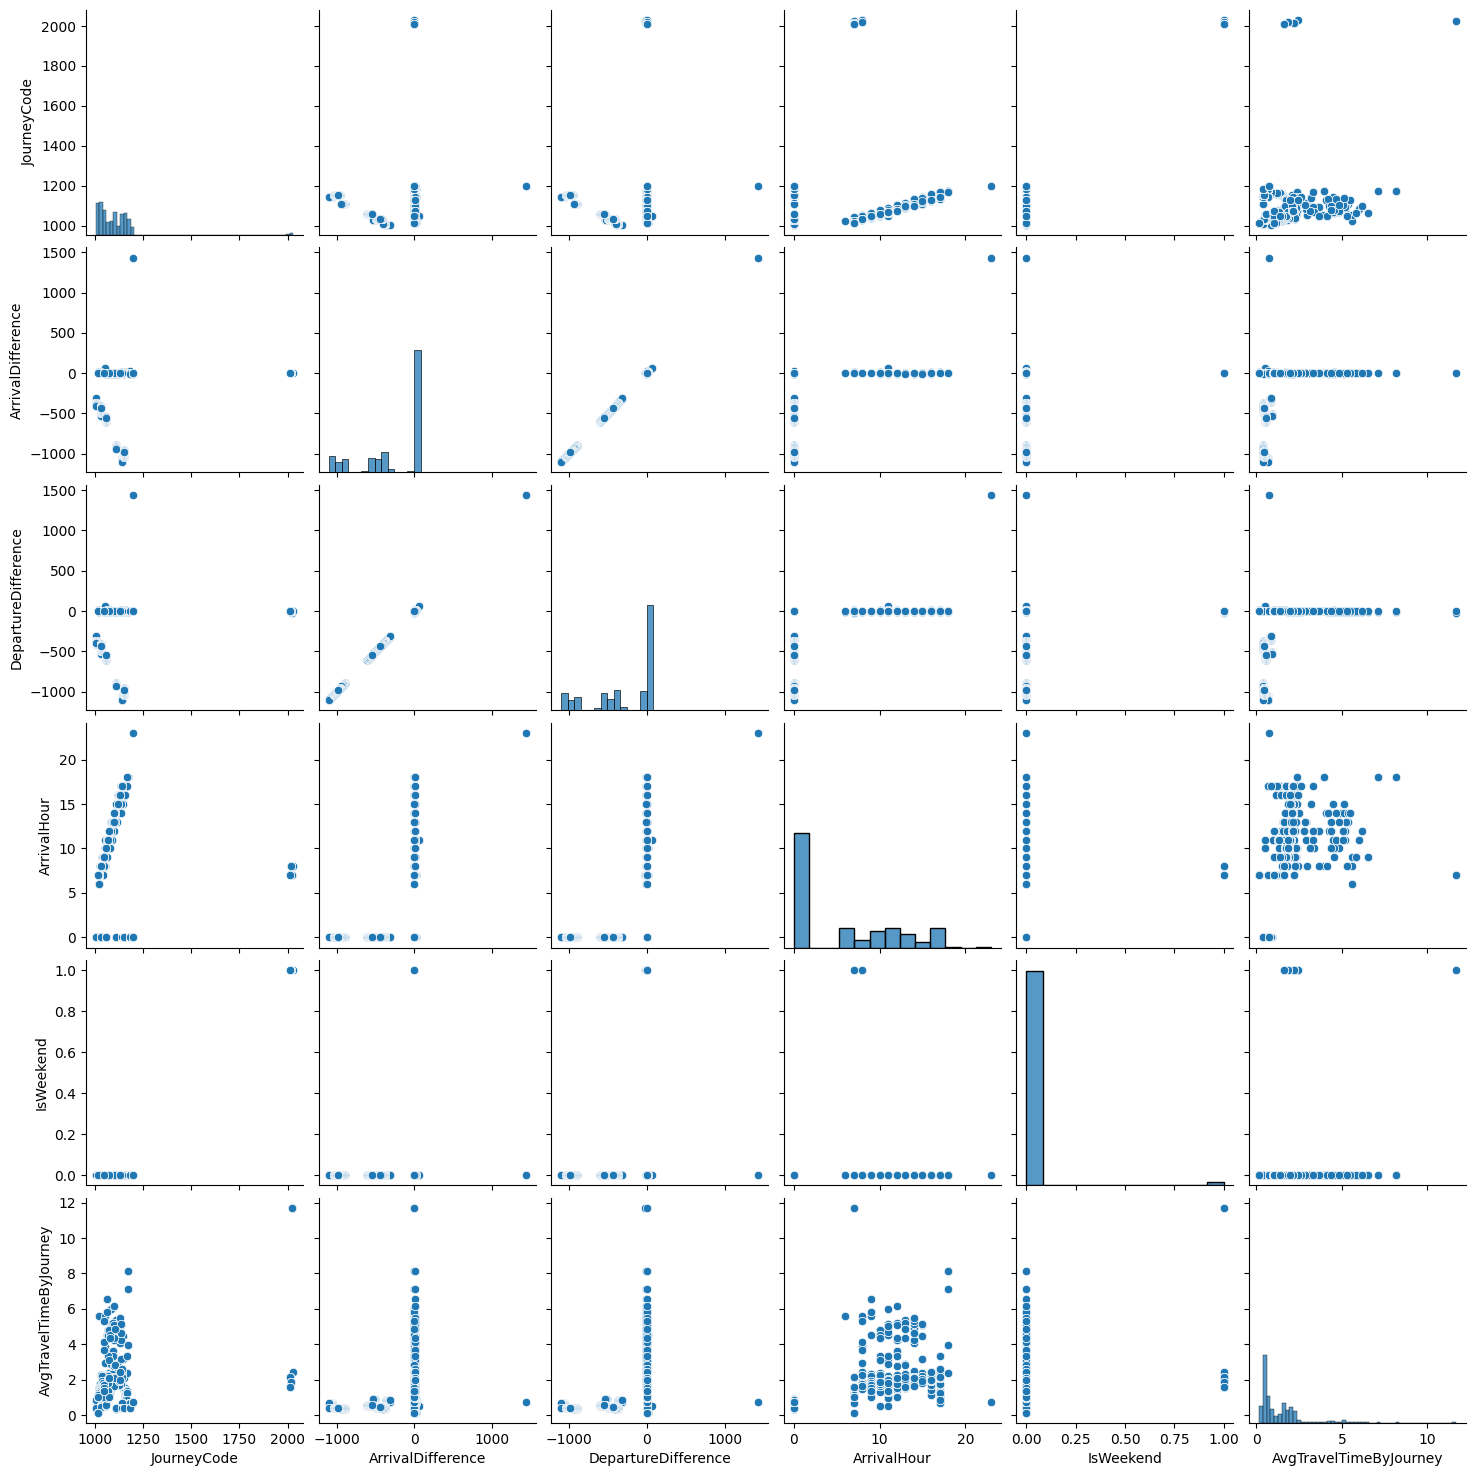

In [11]:
# Converting to a pandas dataframe
pandas_df_features = df_features.select('JourneyCode','ArrivalDifference', 'DepartureDifference','ArrivalHour', 'IsWeekend', 'AvgTravelTimeByJourney').toPandas()

# select  features in the the spark data frame and convert to pandas dataframe 
pandas_df_features = df_features.select(
    'JourneyCode', 'ArrivalDifference', 'DepartureDifference', 'ArrivalHour', 'IsWeekend', 'AvgTravelTimeByJourney'
).toPandas()

# visualize scatter plots between feature pairs
sns.pairplot(pandas_df_features)

# Show the plot
plt.show()

In [12]:
df_features.columns

['id',
 'JourneyCode',
 'ArrivalDifference',
 'DepartureDifference',
 'ArrivalHour',
 'IsWeekend',
 'AvgTravelTimeByJourney']

## Creating vector assembler

In [13]:
#creating the vector assembler
feature_cols = df_features.columns


from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=[col for col in df_features.columns if col != 'id'], 
    outputCol='features'
) #exluding the identifier 'id'

df_features_and_values = assembler.transform(df_features)

# dropping the rest of the column from the df_features dataframe after creating column with the feature_cols
df_features = df_features_and_values.drop('JourneyCode').drop('TravelTime').drop('ArrivalDifference').drop('DepartureDifference').drop('ArrivalHour').drop('IsWeekend').drop('AvgTravelTimeByJourney')

In [14]:
df_features_and_values.columns

['id',
 'JourneyCode',
 'ArrivalDifference',
 'DepartureDifference',
 'ArrivalHour',
 'IsWeekend',
 'AvgTravelTimeByJourney',
 'features']

In [15]:
df_features.columns

['id', 'features']

In [16]:
df_features.show(truncate=False)

+---+--------------------------------------------------------------------------+
|id |features                                                                  |
+---+--------------------------------------------------------------------------+
|1  |[1021.0,-0.15000000596046448,-9.449999809265137,6.0,0.0,5.574999809265137]|
|2  |[1021.0,0.699999988079071,-0.15000000596046448,6.0,0.0,5.574999809265137] |
|3  |[1053.0,1.0833333730697632,-4.316666603088379,8.0,0.0,3.8499999046325684] |
|4  |[1053.0,2.383333444595337,1.0833333730697632,8.0,0.0,3.8499999046325684]  |
|5  |[1081.0,-7.550000190734863,-7.550000190734863,11.0,0.0,5.041666507720947] |
|6  |[1081.0,1.5333333015441895,-7.550000190734863,11.0,0.0,5.041666507720947] |
|7  |[1109.0,1.5499999523162842,-7.866666793823242,13.0,0.0,5.375]             |
|8  |[1109.0,1.8833333253860474,1.5499999523162842,13.0,0.0,5.375]             |
|9  |[1145.0,0.699999988079071,-3.816666603088379,15.0,0.0,3.183333396911621]  |
|10 |[1145.0,1.5499999523162

In [17]:
df_features_and_values.show()

+---+-----------+-----------------+-------------------+-----------+---------+----------------------+--------------------+
| id|JourneyCode|ArrivalDifference|DepartureDifference|ArrivalHour|IsWeekend|AvgTravelTimeByJourney|            features|
+---+-----------+-----------------+-------------------+-----------+---------+----------------------+--------------------+
|  1|     1021.0|            -0.15|              -9.45|          6|        0|                 5.575|[1021.0,-0.150000...|
|  2|     1021.0|              0.7|              -0.15|          6|        0|                 5.575|[1021.0,0.6999999...|
|  3|     1053.0|        1.0833334|         -4.3166666|          8|        0|                  3.85|[1053.0,1.0833333...|
|  4|     1053.0|        2.3833334|          1.0833334|          8|        0|                  3.85|[1053.0,2.3833334...|
|  5|     1081.0|            -7.55|              -7.55|         11|        0|             5.0416665|[1081.0,-7.550000...|
|  6|     1081.0|       

In [18]:
print(feature_cols)

['id', 'JourneyCode', 'ArrivalDifference', 'DepartureDifference', 'ArrivalHour', 'IsWeekend', 'AvgTravelTimeByJourney']


In [19]:
df_features.show()
df_features.count()

+---+--------------------+
| id|            features|
+---+--------------------+
|  1|[1021.0,-0.150000...|
|  2|[1021.0,0.6999999...|
|  3|[1053.0,1.0833333...|
|  4|[1053.0,2.3833334...|
|  5|[1081.0,-7.550000...|
|  6|[1081.0,1.5333333...|
|  7|[1109.0,1.5499999...|
|  8|[1109.0,1.8833333...|
|  9|[1145.0,0.6999999...|
| 10|[1145.0,1.5499999...|
| 11|[1173.0,0.7833333...|
| 12|[1173.0,1.3999999...|
| 13|[1109.0,2.1666667...|
| 14|[1109.0,1.6833332...|
| 15|[1145.0,1.4333332...|
| 16|[1145.0,0.8500000...|
| 17|[1173.0,1.5499999...|
| 18|[1173.0,1.0666667...|
| 19|[1053.0,2.5499999...|
| 20|[1053.0,3.3833334...|
+---+--------------------+
only showing top 20 rows



1771

##  Normalization of features

In [20]:
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

scaler_model =scaler.fit(df_features)

df_scaled = scaler_model.transform(df_features)

df_scaled.show(3, truncate=False)

+---+--------------------------------------------------------------------------+--------------------------------------------------------------------------------------------+
|id |features                                                                  |scaled_features                                                                             |
+---+--------------------------------------------------------------------------+--------------------------------------------------------------------------------------------+
|1  |[1021.0,-0.15000000596046448,-9.449999809265137,6.0,0.0,5.574999809265137]|[0.015625,0.4354044966766459,0.43039789131690653,0.2608695652173913,0.0,0.470036086872814]  |
|2  |[1021.0,0.699999988079071,-0.15000000596046448,6.0,0.0,5.574999809265137] |[0.015625,0.43573912037593376,0.4340677365670158,0.2608695652173913,0.0,0.470036086872814]  |
|3  |[1053.0,1.0833333730697632,-4.316666603088379,8.0,0.0,3.8499999046325684] |[0.046875,0.43589002912445807,0.4324235406590949,0

In [21]:
# renaming the scaled_features as features
df_scaled = df_scaled.drop('features')
df_scaled = df_scaled.withColumnRenamed('scaled_features', 'features')

df_scaled.show(3, truncate=False)

+---+--------------------------------------------------------------------------------------------+
|id |features                                                                                    |
+---+--------------------------------------------------------------------------------------------+
|1  |[0.015625,0.4354044966766459,0.43039789131690653,0.2608695652173913,0.0,0.470036086872814]  |
|2  |[0.015625,0.43573912037593376,0.4340677365670158,0.2608695652173913,0.0,0.470036086872814]  |
|3  |[0.046875,0.43589002912445807,0.4324235406590949,0.34782608695652173,0.0,0.3205776104806935]|
+---+--------------------------------------------------------------------------------------------+
only showing top 3 rows



In [22]:
df_scaled.printSchema()

root
 |-- id: integer (nullable = true)
 |-- features: vector (nullable = true)



In [23]:
df_features_pd = df_scaled.toPandas()
df_features_pd.to_csv('./df_features.csv', index=False)
df_features_pd.head()

,id,features
0,1,"[0.015625, 0.4354044966766459, 0.4303978913169..."
1,2,"[0.015625, 0.43573912037593376, 0.434067736567..."
2,3,"[0.046875, 0.43589002912445807, 0.432423540659..."
3,4,"[0.046875, 0.4364018065786449, 0.4345544185819..."
4,5,"[0.07421875, 0.43249130202497027, 0.4311476445..."


## prepareing features for clustering

In [24]:

# Collecting 'id' and 'features' columns from df_scaled
id_features = df_scaled.select('id', 'features').collect()

# Extract 'id' values and 'features' vectors separately
ids = [row['id'] for row in id_features]  # Extracting ids
features = [row['features'] for row in id_features]  # Extracting features as list of lists

# Convert features to a 2D NumPy array
features_np = np.array(features)

# Convert ids to a NumPy array
ids_np = np.array(ids)

# Now 'ids_np' contains the ids, and 'features_np' contains the feature vectors


In [25]:
#defining function to calculate euclidean distance.

def dist(a, b, axis=1):
    return np.sqrt(np.sum((a - b)**2, axis=axis)) #axis calculates distance between each row or between two matrices


## Undistributed Kmeans function for clustering

In [26]:
def kmeans(X, k, threshold=0.001, seed=12345):
    #fixing random seed
    np.random.seed(seed)

    #randomly choose k examples from the training data
    centroids = X[np.random.permutation(X.shape[0])[:k], :]
    converged = False
    while not converged:
        #assigning each example to its nearest center
        distances = np.zeros((X.shape[0], centroids.shape[0]))
        for i in range(centroids.shape[0]):
            distances[:, i] = dist(X, centroids[i])
        #storing the cluster index of the nearest cluster for each instance.
        nearest_c = np.argmin(distances, axis=1)
        #create new centroids
        new_centroids = np.zeros((centroids.shape[0], centroids.shape[1]))
        for i in range(centroids.shape[0]):
            new_centroids[i, :] = np.mean(X[nearest_c == i, :], axis=0)

        #check if they have converged
        #compute differences between new centroids and previous ones
        
        diff = dist(new_centroids, centroids, axis=None)
        if diff < threshold:
            converged =True
        else:
            centroids = new_centroids
    return centroids, nearest_c


Computing WSSSE - Within-Set Sum of Squared Errors

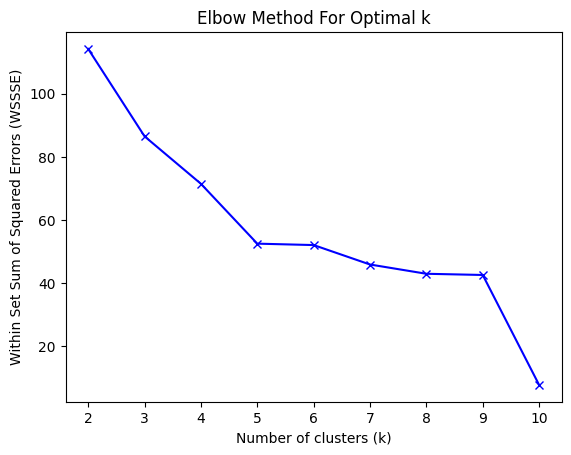

In [27]:
# from pyspark.ml.evaluation import ClusteringEvaluator

#obtaining the optimum number of clusters using Elbow method

#iterating through a range of cluster numbers 
cluster_range = range(2, 11)

cost =np.zeros(len(cluster_range))

for i, k in enumerate(cluster_range):
    centroids, nearest_c = kmeans(features_np, k)  #using kmeans function
    # Computing WSSSE - Within-Set Sum of Squared Errors as the cost
    wssse = 0
    for j in range(len(features_np)):
        wssse += np.sum((features_np[j] - centroids[nearest_c[j]]) ** 2)
    cost[i] = wssse
    


plt.plot(cluster_range, cost, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method For Optimal k')
plt.show()


The optimal number of clusters is typically at the "elbow" of the curve. In this plot, this elbow appears around 𝑘 = 5. This suggests that 5 clusters might be the optimal choice for the data. After k=5, adding more clusters doesn't significantly reduce the WSSSE, implying diminishing returns. However, this method focuses solely on the compactness of the clusters and may not account for how well-separated they are, which is where silhouette scores is important.
The Silhouette Score measures how similar a point is to its own cluster compared to other clusters, providing a way to evaluate both the compactness and separation of clusters.

In [28]:
k = 5
centroids, nearest_c = kmeans(features_np, k)
centroids

array([[0.26881378, 0.43544226, 0.43410139, 0.03593611, 0.1122449 ,
        0.060658  ],
       [0.02078877, 0.25716369, 0.25563434, 0.        , 0.        ,
        0.03332356],
       [0.11133784, 0.43755672, 0.43564401, 0.63562622, 0.        ,
        0.19512977],
       [0.03726581, 0.43619844, 0.4345518 , 0.38001266, 0.        ,
        0.13999509],
       [0.12647372, 0.04453075, 0.0425912 , 0.        , 0.        ,
        0.02531316]])

Running KMeans for k = 2


24/09/13 12:36:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/13 12:36:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Silhouette Score for k=2: 0.5395850092500448
Running KMeans for k = 3
Silhouette Score for k=3: 0.5635289897424846
Running KMeans for k = 4
Silhouette Score for k=4: 0.26067559113936717
Running KMeans for k = 5
Silhouette Score for k=5: 0.45307296739870295
Running KMeans for k = 6
Silhouette Score for k=6: 0.4231477854573256
Running KMeans for k = 7
Silhouette Score for k=7: 0.39251785476003126
Running KMeans for k = 8
Silhouette Score for k=8: 0.3500077692652327
Running KMeans for k = 9
Silhouette Score for k=9: 0.2769236294982465
Running KMeans for k = 10
Silhouette Score for k=10: 0.45557896794947417


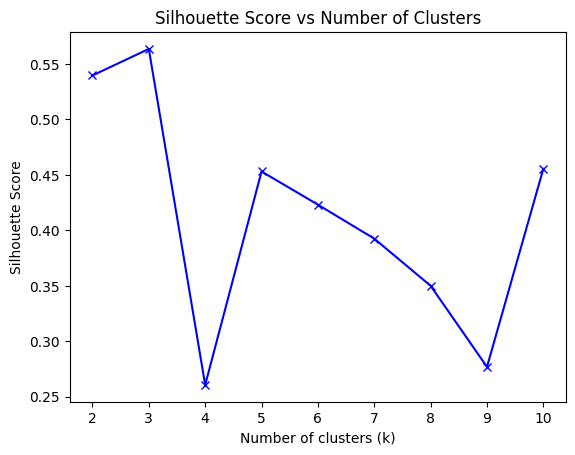

In [29]:
#evaluation of the clustering with sihoulette score
from pyspark.ml.evaluation import ClusteringEvaluator

# Define the range of clusters (k) to test
cluster_range = range(2, 11)

# Initialize a list to store silhouette scores for each k
silhouette_scores = []

# Clustering evaluator for Silhouette Score
evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')

for k in cluster_range:
    print(f"Running KMeans for k = {k}")
    
    # Run custom kmeans function
    centroids, nearest_c = kmeans(features_np, k)
    
    # Convert nearest_c (cluster predictions) to a list of tuples (id, cluster_pred)
    cluster_assignments = [(int(ids_np[i]), int(nearest_c[i])) for i in range(len(ids_np))] 
    
    # Create a new DataFrame with id and cluster assignments
    cluster_df = spark.createDataFrame(cluster_assignments, ['id', 'cluster_pred'])
    
    # Merge the cluster assignments back with the original features DataFrame
    df_with_clusters_test = df_features_and_values.join(cluster_df, on='id', how='inner')
    

    # Rename 'cluster_pred' to 'prediction' 
    df_with_clusters_test = df_with_clusters_test.withColumnRenamed('cluster_pred', 'prediction')

    # Calculate Silhouette Score using the evaluator
    silhouette = evaluator.evaluate(df_with_clusters_test)
    silhouette_scores.append(silhouette)
    
    print(f"Silhouette Score for k={k}: {silhouette}")

# Plot the Silhouette Scores
plt.plot(cluster_range, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()


The highest Silhouette Score is achieved at k = 3 with a value of 0.5635, closely followed by k=2  with a score of 0.5396.
This indicates that the model performs best when the data is clustered into 2 or 3 groups. These scores suggest that the clusters are relatively well-defined for these values of k, with the best separation and cohesion within the clusters Based on the results, the optimal number of clusters appears to be k = 3 where the highest Silhouette Score is observed. This suggests that the data is best represented with 3 clusters, where intra-cluster similarity is maximized, and inter-cluster separation is most distinct.
For any values of k greater than 3, the model starts overfitting or unnecessarily splitting data into more groups than needed, leading to a lower Silhouette Score. The clustering results show that the data is best represented by 3 clusters. Increasing the number of clusters beyond 3 leads to diminishing returns in terms of cluster quality, as indicated by the drop in the Silhouette Score. This result corresponds to the result from the scree plot using principal component analysis, which has the elbow point at 3.

In [30]:
k = 3
centroids, nearest_c = kmeans(features_np, k)
centroids

array([[0.26757317, 0.43548123, 0.43410152, 0.0357537 , 0.11167513,
        0.06069294],
       [0.06667352, 0.16459155, 0.16289391, 0.        , 0.        ,
        0.02980034],
       [0.07384684, 0.43686924, 0.43509119, 0.50624933, 0.        ,
        0.16722377]])

In [31]:
# Running custom kmeans function
k = 3  # Number of clusters
centroids, nearest_c = kmeans(features_np, k)


%time centroids, nearest_c = kmeans(features_np, k)

CPU times: user 1.51 ms, sys: 50 μs, total: 1.56 ms
Wall time: 1.78 ms


In [32]:

# Combining id and cluster assignments
cluster_assignments = [(int(ids_np[i]), int(nearest_c[i])) for i in range(len(ids_np))] #Convert nearest_c  per id to a list of tuples per row

# Creating a new DataFrame with id and cluster assignments
cluster_df = spark.createDataFrame(cluster_assignments, ['id', 'cluster_pred']) #cluster_pred is the prediction for each instance


# Merge with df_scaled
df_with_clusters = df_features_and_values.join(cluster_df, on='id', how='inner')

#displaying the joined dataframe
df_with_clusters.show()
df_with_clusters.groupby('cluster_pred').count().show()




+---+-----------+-----------------+-------------------+-----------+---------+----------------------+--------------------+------------+
| id|JourneyCode|ArrivalDifference|DepartureDifference|ArrivalHour|IsWeekend|AvgTravelTimeByJourney|            features|cluster_pred|
+---+-----------+-----------------+-------------------+-----------+---------+----------------------+--------------------+------------+
|  1|     1021.0|            -0.15|              -9.45|          6|        0|                 5.575|[1021.0,-0.150000...|           2|
|  2|     1021.0|              0.7|              -0.15|          6|        0|                 5.575|[1021.0,0.6999999...|           2|
|  3|     1053.0|        1.0833334|         -4.3166666|          8|        0|                  3.85|[1053.0,1.0833333...|           2|
|  4|     1053.0|        2.3833334|          1.0833334|          8|        0|                  3.85|[1053.0,2.3833334...|           2|
|  5|     1081.0|            -7.55|              -7.55|

In [33]:
# Filtering the DataFrame to get rows where 'cluster_pred' is null
null_cluster_df = df_with_clusters.filter(df_with_clusters['cluster_pred'].isNull())

# Show the DataFrame with null cluster predictions
null_cluster_df.show(truncate=False)

# count the number of such rows
null_count = null_cluster_df.count()
print(f"Number of rows with null cluster predictions: {null_count}")


+---+-----------+-----------------+-------------------+-----------+---------+----------------------+--------+------------+
|id |JourneyCode|ArrivalDifference|DepartureDifference|ArrivalHour|IsWeekend|AvgTravelTimeByJourney|features|cluster_pred|
+---+-----------+-----------------+-------------------+-----------+---------+----------------------+--------+------------+
+---+-----------+-----------------+-------------------+-----------+---------+----------------------+--------+------------+

Number of rows with null cluster predictions: 0


In [34]:
df_with_clusters.show()

+---+-----------+-----------------+-------------------+-----------+---------+----------------------+--------------------+------------+
| id|JourneyCode|ArrivalDifference|DepartureDifference|ArrivalHour|IsWeekend|AvgTravelTimeByJourney|            features|cluster_pred|
+---+-----------+-----------------+-------------------+-----------+---------+----------------------+--------------------+------------+
|  1|     1021.0|            -0.15|              -9.45|          6|        0|                 5.575|[1021.0,-0.150000...|           2|
|  2|     1021.0|              0.7|              -0.15|          6|        0|                 5.575|[1021.0,0.6999999...|           2|
|  3|     1053.0|        1.0833334|         -4.3166666|          8|        0|                  3.85|[1053.0,1.0833333...|           2|
|  4|     1053.0|        2.3833334|          1.0833334|          8|        0|                  3.85|[1053.0,2.3833334...|           2|
|  5|     1081.0|            -7.55|              -7.55|

## Scatterplot of features against clusters


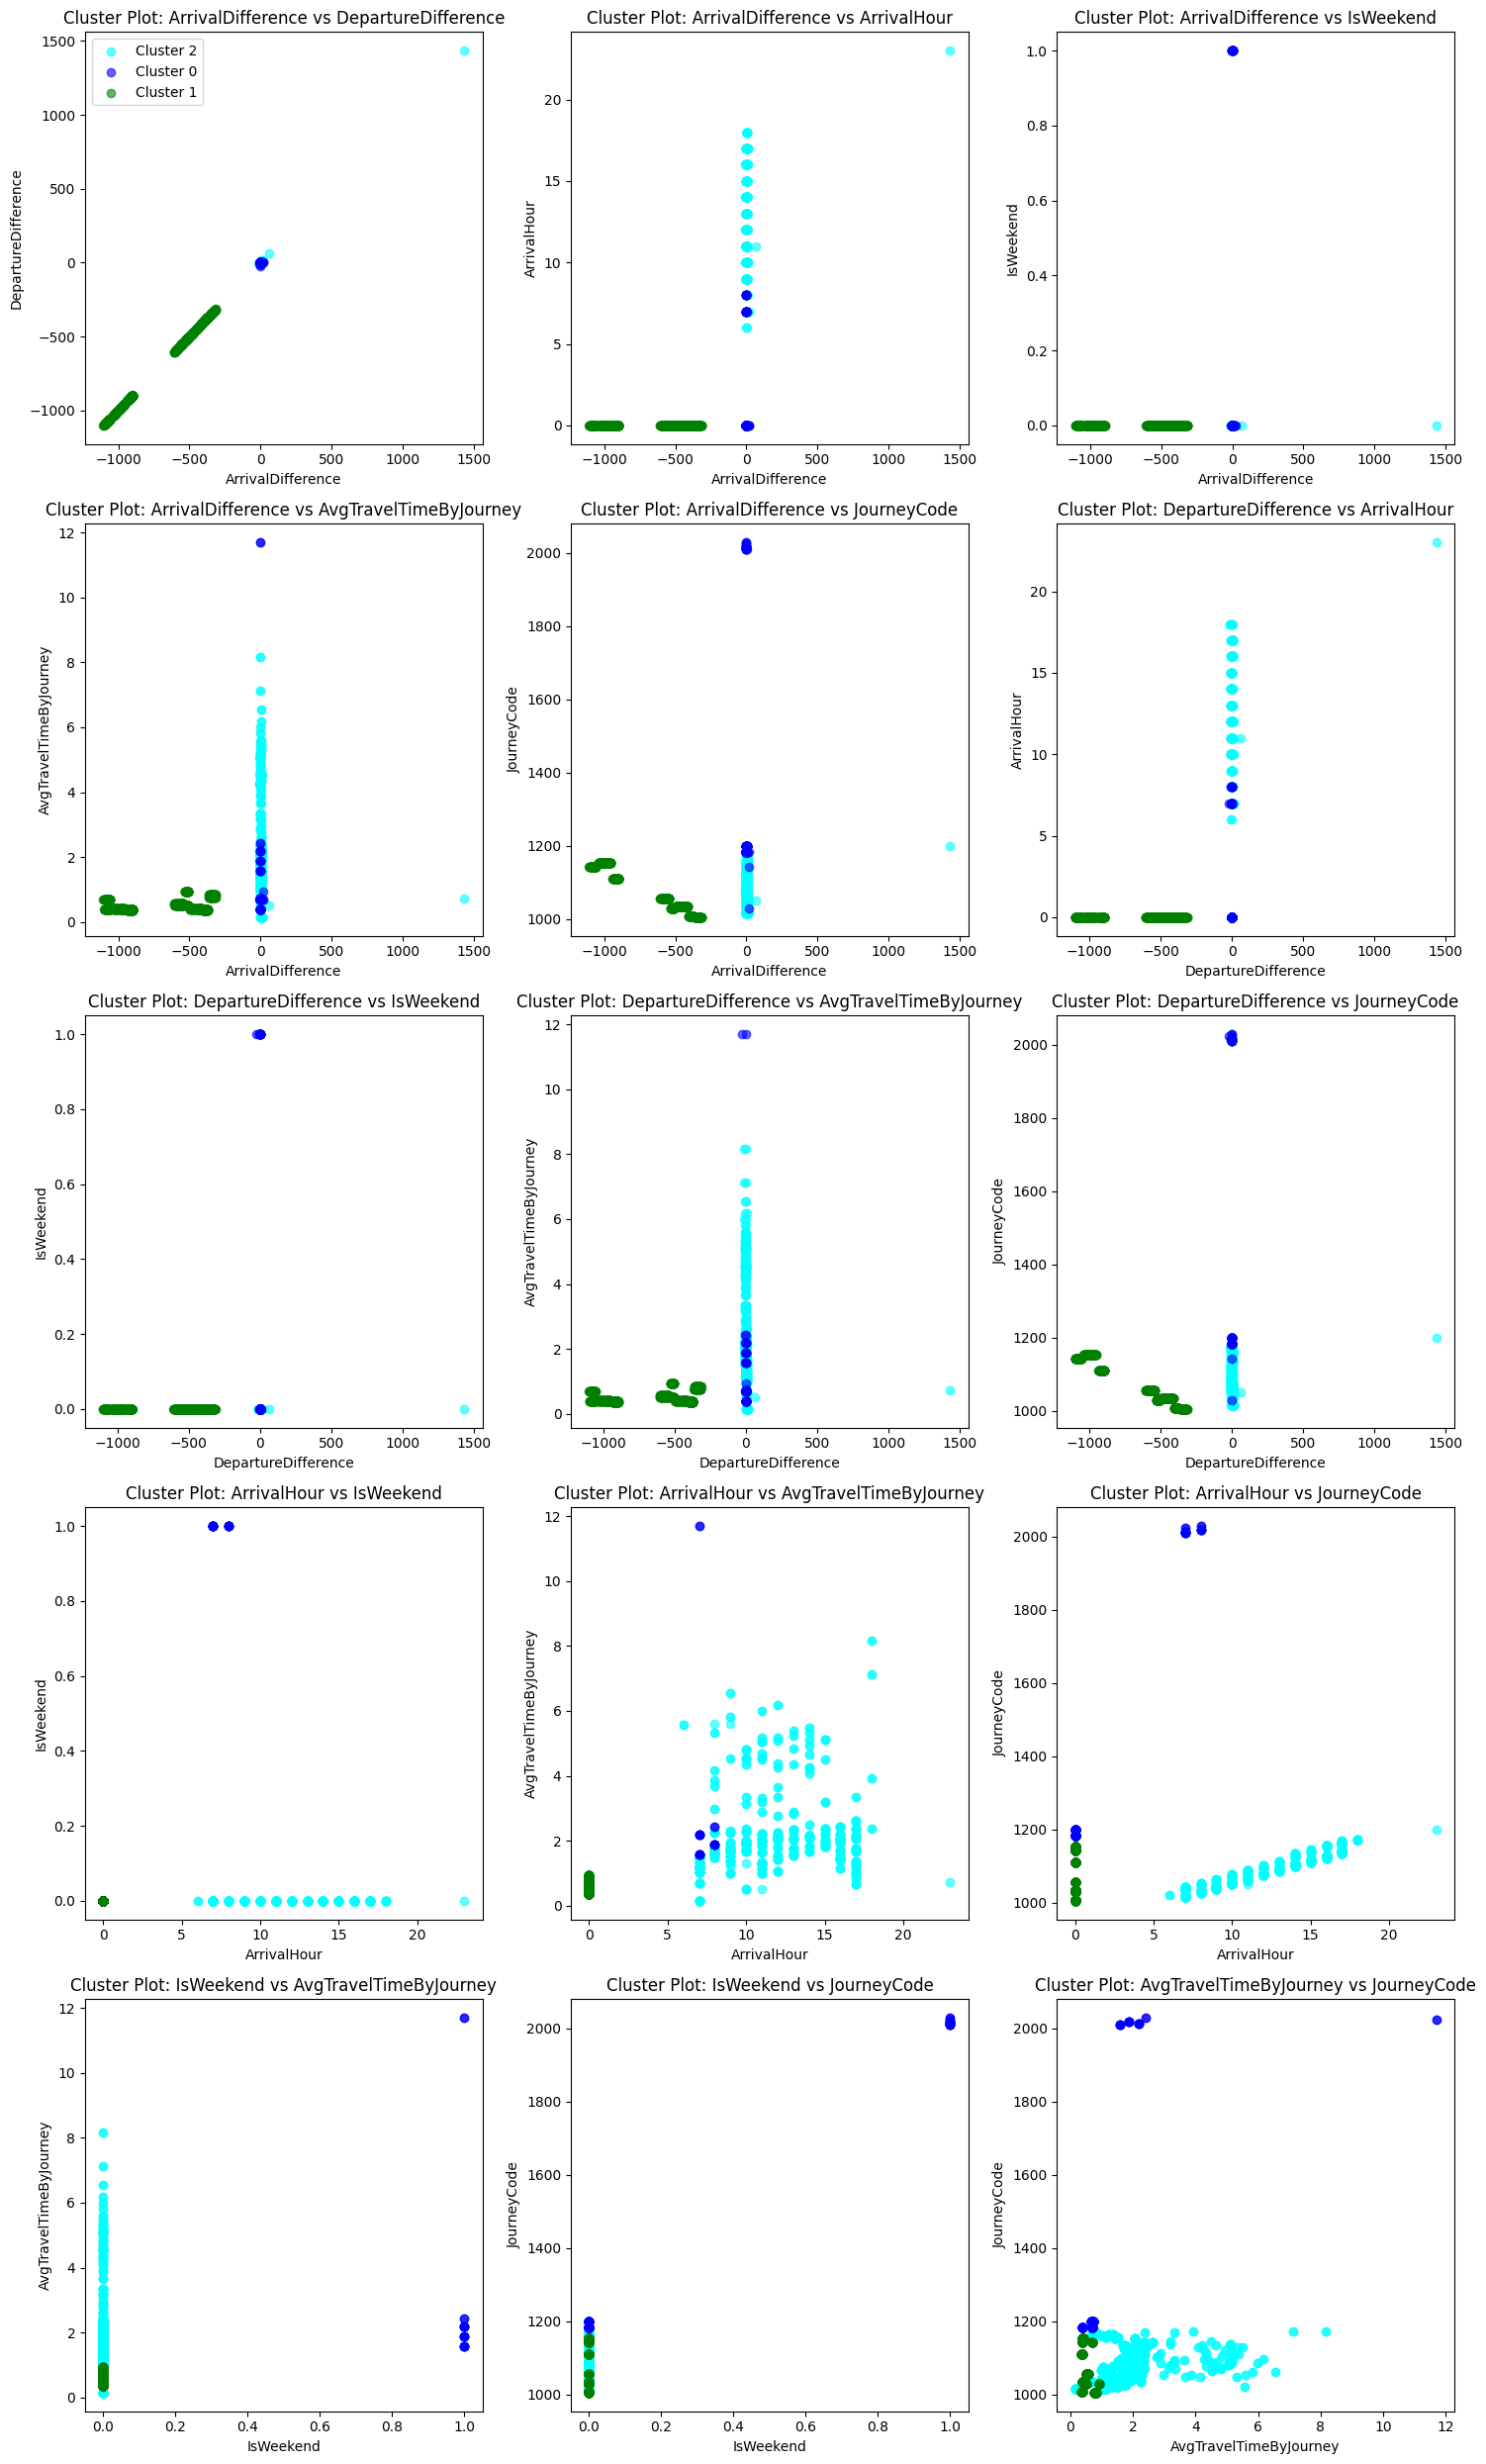

In [35]:
import matplotlib.pyplot as plt
from itertools import combinations

# Convert your Spark DataFrame to Pandas for easier plotting
pandas_df = df_with_clusters.select(
    'ArrivalDifference', 'DepartureDifference', 'ArrivalHour', 'IsWeekend', 'AvgTravelTimeByJourney', 'JourneyCode', 'cluster_pred'
).toPandas()

# color map for the clusters
colors = ['blue', 'green', 'cyan', 'purple', 'orange']  # Adjust the number of colors to match the number of clusters

# List of features to plot in pairs
features = ['ArrivalDifference', 'DepartureDifference', 'ArrivalHour', 'IsWeekend', 'AvgTravelTimeByJourney', 'JourneyCode']

# Set the number of rows and columns for the grid layout
n_cols = 3  # Number of plots in each row
n_rows = (len(list(combinations(features, 2))) + n_cols - 1) // n_cols  # calculate rows

# Create a figure with a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.ravel()  # Flatten the axes array for easier indexing

# Looping through each pair of features using combinations
for idx, feature_pair in enumerate(combinations(features, 2)):
    
    ax = axes[idx]  # Get the current axis
    # Plot each cluster in a different color
    for cluster in pandas_df['cluster_pred'].unique():
        data = pandas_df[pandas_df['cluster_pred'] == cluster]
        ax.scatter(data[feature_pair[0]], data[feature_pair[1]], 
                   c=colors[cluster], label=f'Cluster {cluster}', alpha=0.6)
    
    # Adding title and labels
    ax.set_title(f'Cluster Plot: {feature_pair[0]} vs {feature_pair[1]}')
    ax.set_xlabel(feature_pair[0])
    ax.set_ylabel(feature_pair[1])
    
    # Adding a legend only for the first subplot
    if idx == 0:
        ax.legend()

# Hide any remaining empty subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

#prevent overlapping
plt.tight_layout()

# Display the grid of plots
plt.show()


## Computing Silhouette Score for Train Data

In [36]:

from pyspark.ml.evaluation import ClusteringEvaluator

# Initialize the ClusteringEvaluator
evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='cluster_pred', metricName='silhouette', distanceMeasure='squaredEuclidean')

# Evaluate the clustering performance on test data
silhouette_score_test = evaluator.evaluate(df_with_clusters)

print(f'Silhouette Score for Train Data: {silhouette_score_test}')


Silhouette Score for Train Data: 0.5635289897424846


In [37]:

# # Perform the join to add the 'TravelTime' column back into df_with_clusters
df_with_clusters = df_with_clusters.join(df.select("id", "TravelTime"), on="id", how="inner")



In [38]:
# Select the 'TravelTime' column and get distinct values
unique_travel_times = df_with_clusters.select("TravelTime").distinct()

# Show the unique values
unique_travel_times.show(truncate=False)

+----------+
|TravelTime|
+----------+
|1.8666667 |
|2.6666667 |
|8.333333  |
|7.4333334 |
|0.56666666|
|0.78333336|
|4.95      |
|7.05      |
|5.0       |
|3.3333333 |
|2.35      |
|2.1666667 |
|2.3666666 |
|2.3166666 |
|1.8166667 |
|2.5       |
|1.6166667 |
|0.21666667|
|0.73333335|
|3.5166667 |
+----------+
only showing top 20 rows



In [39]:
df_with_clusters.show()

+---+-----------+-----------------+-------------------+-----------+---------+----------------------+--------------------+------------+----------+
| id|JourneyCode|ArrivalDifference|DepartureDifference|ArrivalHour|IsWeekend|AvgTravelTimeByJourney|            features|cluster_pred|TravelTime|
+---+-----------+-----------------+-------------------+-----------+---------+----------------------+--------------------+------------+----------+
|  1|     1021.0|            -0.15|              -9.45|          6|        0|                 5.575|[1021.0,-0.150000...|           2|       9.3|
|  2|     1021.0|              0.7|              -0.15|          6|        0|                 5.575|[1021.0,0.6999999...|           2|      1.85|
|  3|     1053.0|        1.0833334|         -4.3166666|          8|        0|                  3.85|[1053.0,1.0833333...|           2|       5.4|
|  4|     1053.0|        2.3833334|          1.0833334|          8|        0|                  3.85|[1053.0,2.3833334...|   

## Kmeans and ANN prediction on test data

In [40]:
# reading data schema
from pyspark.sql.types import *
schema  = StructType(
    [   
        StructField('id', IntegerType(), False),
        StructField('JourneyCode', FloatType(), True),
        StructField('TravelTime', FloatType(), True),
        StructField('ArrivalDifference', FloatType(), True),
        StructField('DepartureDifference', FloatType(), True),
        StructField('HourOfDay', IntegerType(), True),
        StructField('ArrivalHour', IntegerType(), True),
        StructField('DepartureHour', IntegerType(), True),
        StructField('IsWeekend', IntegerType(), True),
        StructField('AvgTravelTimeByJourney', FloatType(), True),
    ]
)

#fetching test data feature engineering stage.
test_df = spark.read.format('csv').option('header', 'true')\
                .schema(schema).load('./Updated_test_data.csv')

In [41]:
test_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- JourneyCode: float (nullable = true)
 |-- TravelTime: float (nullable = true)
 |-- ArrivalDifference: float (nullable = true)
 |-- DepartureDifference: float (nullable = true)
 |-- HourOfDay: integer (nullable = true)
 |-- ArrivalHour: integer (nullable = true)
 |-- DepartureHour: integer (nullable = true)
 |-- IsWeekend: integer (nullable = true)
 |-- AvgTravelTimeByJourney: float (nullable = true)



In [42]:
test_df.show()

+---+-----------+----------+-----------------+-------------------+---------+-----------+-------------+---------+----------------------+
| id|JourneyCode|TravelTime|ArrivalDifference|DepartureDifference|HourOfDay|ArrivalHour|DepartureHour|IsWeekend|AvgTravelTimeByJourney|
+---+-----------+----------+-----------------+-------------------+---------+-----------+-------------+---------+----------------------+
|  1|     1053.0|       3.2|              1.8|               -1.4|        8|          8|            8|        0|             2.6083333|
|  2|     1053.0| 2.0166667|        2.8166666|                1.8|        8|          8|            8|        0|             2.6083333|
|  3|     1081.0|  4.383333|       0.53333336|              -3.85|       11|         11|           11|        0|             2.5583334|
|  4|     1081.0|0.73333335|       0.26666668|         0.53333336|       11|         11|           11|        0|             2.5583334|
|  5|     1109.0|       9.7|        3.8666666|  

In [43]:
#removing unnecessary columns to create attributes dataframes from extracted useful attributes in feature engineeering
test_df_features = test_df.drop('TravelTime').drop('HourOfDay').drop('DepartureHour')
# dropping the target variable and the other repititve features


In [44]:
test_df_features.columns

['id',
 'JourneyCode',
 'ArrivalDifference',
 'DepartureDifference',
 'ArrivalHour',
 'IsWeekend',
 'AvgTravelTimeByJourney']

In [45]:
#creating the vector assembler
test_feature_cols = test_df_features.columns

In [46]:
from pyspark.ml.feature import VectorAssembler
test_assembler = VectorAssembler(
    inputCols=[col for col in test_df_features.columns if col != 'id'], 
    outputCol='features'
)

test_df_features_and_values = test_assembler.transform(test_df_features)

# dropping the rest of the column from the df_features dataframe after creating column with the feature_cols
test_df_features = test_df_features_and_values.drop('JourneyCode').drop('TravelTime').drop('ArrivalDifference').drop('DepartureDifference').drop('ArrivalHour').drop('IsWeekend').drop('AvgTravelTimeByJourney')

In [47]:
test_df_features_and_values.columns
test_df_features.columns
test_df_features.show()
test_df_features.count()

+---+--------------------+
| id|            features|
+---+--------------------+
|  1|[1053.0,1.7999999...|
|  2|[1053.0,2.8166666...|
|  3|[1081.0,0.5333333...|
|  4|[1081.0,0.2666666...|
|  5|[1109.0,3.8666665...|
|  6|[1109.0,4.1166667...|
|  7|[1145.0,7.1666665...|
|  8|[1145.0,7.1666665...|
|  9|[1173.0,1.3500000...|
| 10|[1173.0,0.3499999...|
| 11|[1053.0,-3.083333...|
| 12|[1053.0,2.25,-3.0...|
| 13|[1081.0,-3.916666...|
| 14|[1081.0,4.1999998...|
| 15|[3045.0,31.350000...|
| 16|[1081.0,-0.066666...|
| 17|[1081.0,1.4333332...|
| 18|[1109.0,0.9333333...|
| 19|[1109.0,3.0499999...|
| 20|[1153.0,-8.649999...|
+---+--------------------+
only showing top 20 rows



992

In [48]:
from pyspark.ml.feature import MinMaxScaler
test_scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

scaler_model =test_scaler.fit(test_df_features)

test_df_scaled = scaler_model.transform(test_df_features)

test_df_scaled.show(3, truncate=False)

+---+--------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------+
|id |features                                                                  |scaled_features                                                                                        |
+---+--------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------+
|1  |[1053.0,1.7999999523162842,-1.399999976158142,8.0,0.0,2.6083333492279053] |[0.023529411764705882,0.9739203340136197,0.9702965923061879,0.4444444444444444,0.0,0.08675659447392786]|
|2  |[1053.0,2.816666603088379,1.7999999523162842,8.0,0.0,2.6083333492279053]  |[0.023529411764705882,0.9748176039387149,0.9731339328104486,0.4444444444444444,0.0,0.08675659447392786]|
|3  |[1081.0,0.5333333611488342,-3.8499999046325684,11.0,0.0,2.558333396911

In [49]:
test_df_scaled = test_df_scaled.drop('features')
test_df_scaled = test_df_scaled.withColumnRenamed('scaled_features', 'features')

test_df_scaled.show(3, truncate=False)

+---+-------------------------------------------------------------------------------------------------------+
|id |features                                                                                               |
+---+-------------------------------------------------------------------------------------------------------+
|1  |[0.023529411764705882,0.9739203340136197,0.9702965923061879,0.4444444444444444,0.0,0.08675659447392786]|
|2  |[0.023529411764705882,0.9748176039387149,0.9731339328104486,0.4444444444444444,0.0,0.08675659447392786]|
|3  |[0.03725490196078431,0.9728024239921645,0.9681242534974773,0.611111111111111,0.0,0.08491723381346832]  |
+---+-------------------------------------------------------------------------------------------------------+
only showing top 3 rows



In [50]:
test_df_scaled.printSchema()

root
 |-- id: integer (nullable = true)
 |-- features: vector (nullable = true)



In [51]:

# Collecting 'id' and 'features' columns from test_df_scaled
test_id_features = test_df_scaled.select('id', 'features').collect()

# Extract 'id' values and 'features' vectors separately
ids_test = [row['id'] for row in test_id_features]  # Extracting ids
features_test = [row['features'] for row in test_id_features]  # Extracting features as list of lists

# Convert features to a 2D NumPy array
test_features_np = np.array(features_test)

# Convert ids to a NumPy array
test_ids_np = np.array(ids_test)

# Now 'test_ids_np' contains the ids, and 'test_features_np' contains the feature vectors


## Making prediction of clusters on test data

In [52]:
# Assign test data to nearest cluster using the trained centroids

def predict_kmeans(X, centroids):
    distances = np.zeros((X.shape[0], centroids.shape[0]))
    for i in range(centroids.shape[0]):
        distances[:, i] = dist(X, centroids[i])
    # Predict the cluster as the nearest centroid
    nearest_c = np.argmin(distances, axis=1)
    return nearest_c

# Predict the cluster for test data using the centroids from the training phase
nearest_c_test = predict_kmeans(test_features_np, centroids)

#Combining test ids and predicted clusters
test_cluster_assignments = [(int(test_ids_np[i]), int(nearest_c_test[i])) for i in range(len(test_ids_np))]

#Creating a new DataFrame for the test data with id and cluster assignments
test_cluster_df = spark.createDataFrame(test_cluster_assignments, ['id', 'cluster_pred'])

#Merge test_cluster_df with test_df
df_with_test_clusters = test_df.join(test_cluster_df, on='id', how='inner')

#Displaying the test data with predicted clusters
df_with_test_clusters.show()

#showing instances are in each predicted cluster for the test data
df_with_test_clusters.groupby('cluster_pred').count().show()


+---+-----------+----------+-----------------+-------------------+---------+-----------+-------------+---------+----------------------+------------+
| id|JourneyCode|TravelTime|ArrivalDifference|DepartureDifference|HourOfDay|ArrivalHour|DepartureHour|IsWeekend|AvgTravelTimeByJourney|cluster_pred|
+---+-----------+----------+-----------------+-------------------+---------+-----------+-------------+---------+----------------------+------------+
|  1|     1053.0|       3.2|              1.8|               -1.4|        8|          8|            8|        0|             2.6083333|           2|
|  2|     1053.0| 2.0166667|        2.8166666|                1.8|        8|          8|            8|        0|             2.6083333|           2|
|  3|     1081.0|  4.383333|       0.53333336|              -3.85|       11|         11|           11|        0|             2.5583334|           2|
|  4|     1081.0|0.73333335|       0.26666668|         0.53333336|       11|         11|           11|    

In [53]:
# Join df_with_test_clusters with test_df_scaled on 'id' to bring back the 'features' column
df_with_test_clusters_and_features = df_with_test_clusters.join(test_df_scaled.select('id', 'features'), on='id', how='inner')
df_with_test_clusters_and_features.show()

+---+-----------+----------+-----------------+-------------------+---------+-----------+-------------+---------+----------------------+------------+--------------------+
| id|JourneyCode|TravelTime|ArrivalDifference|DepartureDifference|HourOfDay|ArrivalHour|DepartureHour|IsWeekend|AvgTravelTimeByJourney|cluster_pred|            features|
+---+-----------+----------+-----------------+-------------------+---------+-----------+-------------+---------+----------------------+------------+--------------------+
|  1|     1053.0|       3.2|              1.8|               -1.4|        8|          8|            8|        0|             2.6083333|           2|[0.02352941176470...|
|  2|     1053.0| 2.0166667|        2.8166666|                1.8|        8|          8|            8|        0|             2.6083333|           2|[0.02352941176470...|
|  3|     1081.0|  4.383333|       0.53333336|              -3.85|       11|         11|           11|        0|             2.5583334|           2|[0

## Visualizing the feature pairs with clusters.

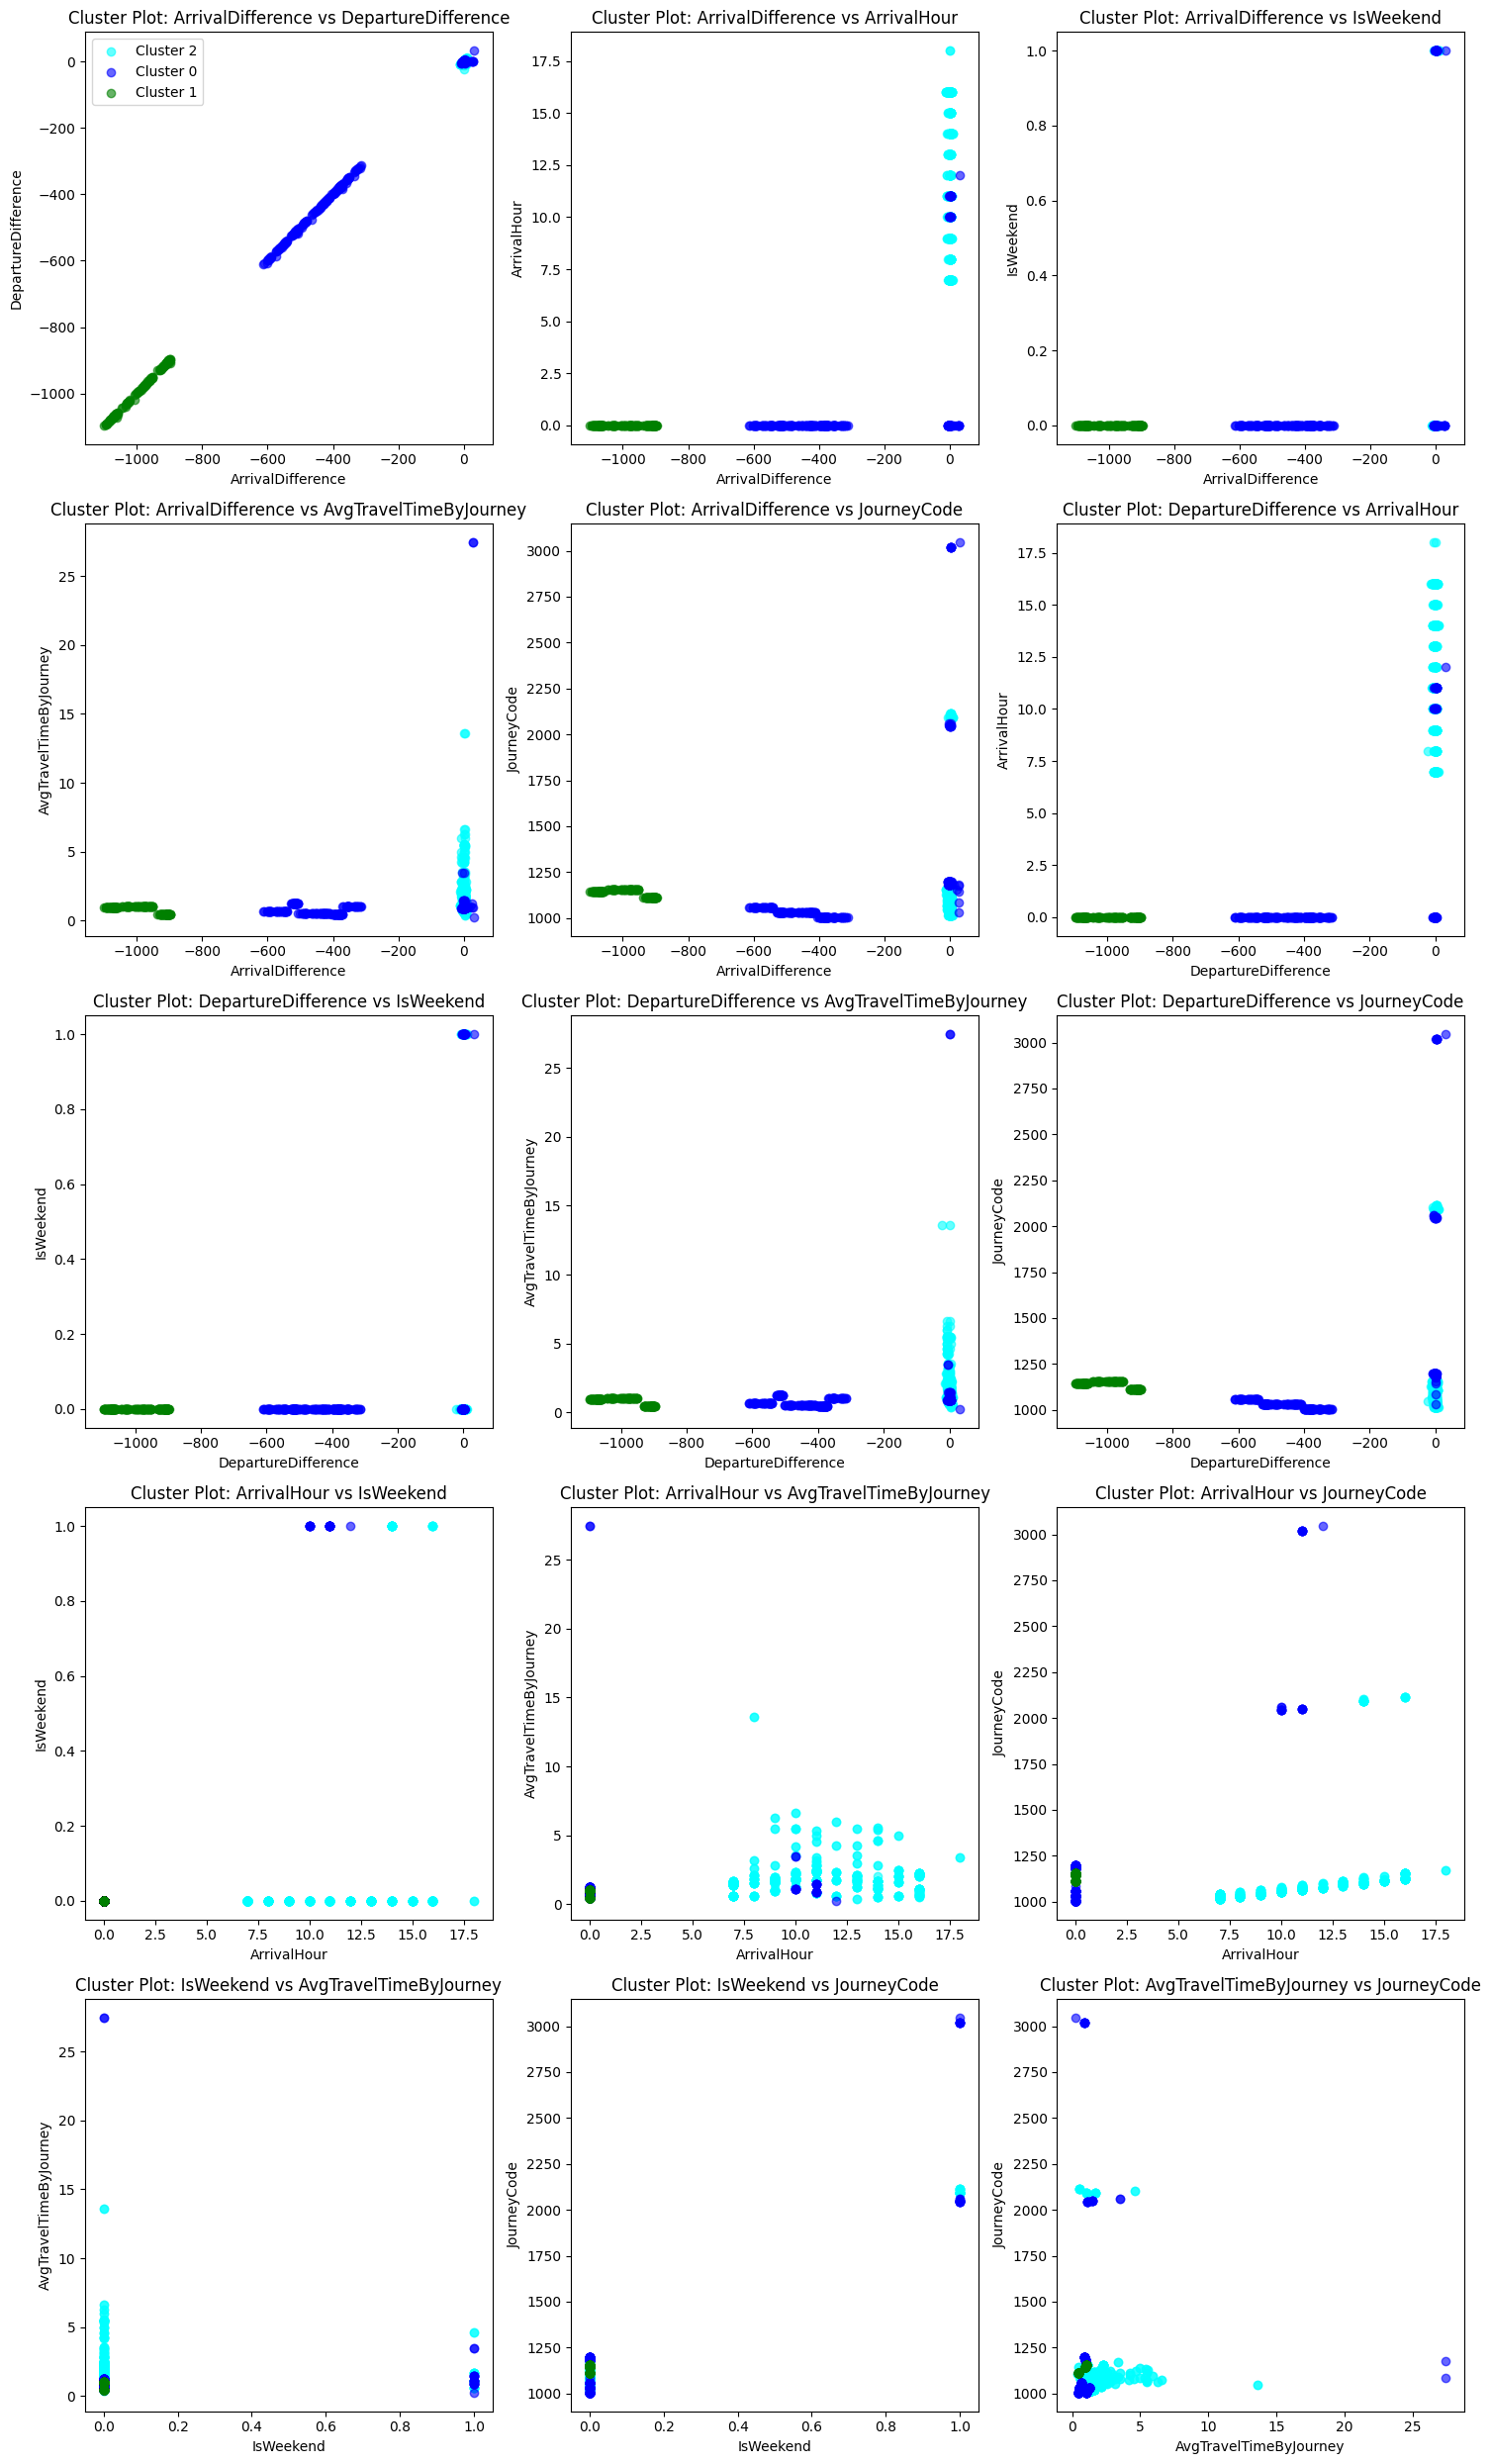

In [54]:

from itertools import combinations
# Number of rows and columns for the grid layout
n_cols = 3  # Number of plots in each row
n_rows = (len(list(combinations(features, 2))) + n_cols - 1) // n_cols  # Calculate rows 

# Convert your Spark DataFrame to Pandas for easier plotting
test_pandas_df = df_with_test_clusters.select(
    'ArrivalDifference', 'DepartureDifference','ArrivalHour', 'IsWeekend', 'AvgTravelTimeByJourney', 'JourneyCode', 'cluster_pred'
).toPandas()

# Define a color map for the clusters
colors = ['blue', 'green', 'cyan', 'purple', 'orange']  # Adjust the number of colors to match the number of clusters

# List of features to plot in pairs
features = ['ArrivalDifference', 'DepartureDifference', 'ArrivalHour', 'IsWeekend', 'AvgTravelTimeByJourney', 'JourneyCode']

# Create a figure with a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.ravel()  # Flatten the axes array for easier indexing

# Loop through each pair of features using combinations
for idx, feature_pair in enumerate(combinations(features, 2)):
    
    ax = axes[idx]  # Get the current axis
    # Plot each cluster in a different color
    for cluster in test_pandas_df['cluster_pred'].unique():
        data = test_pandas_df[test_pandas_df['cluster_pred'] == cluster]
        ax.scatter(data[feature_pair[0]], data[feature_pair[1]], 
                   c=colors[cluster], label=f'Cluster {cluster}', alpha=0.6)
    
    # Adding title and labels
    ax.set_title(f'Cluster Plot: {feature_pair[0]} vs {feature_pair[1]}')
    ax.set_xlabel(feature_pair[0])
    ax.set_ylabel(feature_pair[1])
    
    # Adding a legend only for the first subplot
    if idx == 0:
        ax.legend()

# Hide any remaining empty subplots 
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# prevent overlapping
plt.tight_layout()

# Display the grid of plots
plt.show()

## Computing Silhouette Score for Test Data

In [55]:
#evaluating cluster of test set with sihoulette score.
from pyspark.ml.evaluation import ClusteringEvaluator

# Initialize the ClusteringEvaluator
evaluator = ClusteringEvaluator(featuresCol='features', predictionCol='cluster_pred', metricName='silhouette', distanceMeasure='squaredEuclidean')

# Evaluate the clustering performance on test data
silhouette_score_test = evaluator.evaluate(df_with_test_clusters_and_features)

print(f'Silhouette Score for Test Data: {silhouette_score_test}')


Silhouette Score for Test Data: 0.6634078164005701


It is observed that the Silhouette Score improved for the test data 0.6634 compared to train data score of 0.5635

obtain range for classification

In [56]:
from pyspark.sql import functions as F
#obtain range for classification
# Calculate and print the minimum and maximum TravelTime in the training dataset
min_max_train = df_with_clusters.agg(
    F.min('TravelTime').alias('min_travel_time'),
    F.max('TravelTime').alias('max_travel_time')
)

# Display the min and max travel times for the training dataset
min_max_train.show()

# Calculate and print the minimum and maximum TravelTime in the test dataset
min_max_test = df_with_test_clusters_and_features.agg(
    F.min('TravelTime').alias('min_travel_time'),
    F.max('TravelTime').alias('max_travel_time')
)

# Display the min and max travel times for the test dataset
min_max_test.show()


+---------------+---------------+
|min_travel_time|max_travel_time|
+---------------+---------------+
|            0.0|      23.383333|
+---------------+---------------+

+---------------+---------------+
|min_travel_time|max_travel_time|
+---------------+---------------+
|            0.0|      27.433332|
+---------------+---------------+



In [57]:
# Group by TravelTime and count the number of occurrences for each value
travel_time_occurrences = df_with_clusters.groupBy('TravelTime')\
    .agg(F.count('TravelTime').alias('occurrences'))\
    .orderBy(F.desc('occurrences'))  # Sort by the number of occurrences in descending order

# Show the travel times with their corresponding number of occurrences
travel_time_occurrences.show()

+----------+-----------+
|TravelTime|occurrences|
+----------+-----------+
|       0.0|        665|
|       0.5|         42|
|       1.8|         32|
| 1.6833333|         25|
|0.73333335|         23|
|       1.6|         22|
|       1.0|         21|
| 1.2333333|         20|
|      0.25|         19|
|0.76666665|         19|
| 1.6333333|         18|
| 0.6666667|         18|
| 1.2666667|         18|
| 1.6166667|         17|
| 1.8333334|         17|
|       0.7|         17|
| 1.7333333|         16|
|       1.3|         16|
|      0.35|         15|
|      1.65|         15|
+----------+-----------+
only showing top 20 rows



## Evaluation with Accuracy, Precision and F1 Score

In [58]:
from pyspark.sql import functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt

# Define bins for the TravelTime in both train and test data

# Bin TravelTime in the training data
df_with_clusters = df_with_clusters.withColumn(
    'binned_travel_time',
    when(col('TravelTime') == 0, 'Zero') 
    .when((col('TravelTime') > 0) & (col('TravelTime') < 5), 'Low')
    .when((col('TravelTime') >= 5) & (col('TravelTime') < 10), 'Moderate')
    .when((col('TravelTime') >= 10) & (col('TravelTime') < 15), 'High')
    .otherwise('Very High')
)

# Bin TravelTime in the test data
df_with_test_clusters_and_features = df_with_test_clusters_and_features.withColumn(
    'binned_travel_time', 
    when(col('TravelTime') == 0, 'Zero') 
    .when((col('TravelTime') > 0) & (col('TravelTime') < 5), 'Low')
    .when((col('TravelTime') >= 5) & (col('TravelTime') < 10), 'Moderate')
    .when((col('TravelTime') >= 10) & (col('TravelTime') < 15), 'High')
    .otherwise('Very High')
)

# Convert the binned travel time to numeric labels in training and test data
df_with_clusters = df_with_clusters.withColumn(
    'binned_travel_time_numeric', 
    when(col('binned_travel_time') == 'Zero', 0) 
    .when(col('binned_travel_time') == 'Low', 1)
    .when(col('binned_travel_time') == 'Moderate', 2)
    .when(col('binned_travel_time') == 'High', 3)
    .when(col('binned_travel_time') == 'Very High', 4)
)

df_with_test_clusters_and_features = df_with_test_clusters_and_features.withColumn(
    'binned_travel_time_numeric', 
     when(col('binned_travel_time') == 'Zero', 0) 
    .when(col('binned_travel_time') == 'Low', 1)
    .when(col('binned_travel_time') == 'Moderate', 2)
    .when(col('binned_travel_time') == 'High', 3)
    .when(col('binned_travel_time') == 'Very High', 4)
)

# Train ANN model for each cluster

# Empty list to hold predictions for all clusters
all_predictions = []

for cluster_num in range(3):  # Assuming 4 clusters
    print(f"Training ANN model for Cluster {cluster_num}")
    
    # Filter data for the current cluster
    df_cluster = df_with_clusters.filter(col("cluster_pred") == cluster_num)
    test_df_cluster = df_with_test_clusters_and_features.filter(col("cluster_pred") == cluster_num)

    # Drop unnecessary columns in training data
    train_data = df_cluster.drop('binned_travel_time', 'cluster_pred')

    # Drop unnecessary columns in test data
    test_data = test_df_cluster.drop('binned_travel_time')

    # Define the ANN structure and train the model
    layers = [6, 5, 5, 5]  # 6 input neurons, 5 in hidden layers, 4 output neurons for 4 classes
    ann = MultilayerPerceptronClassifier(featuresCol="features", labelCol="binned_travel_time_numeric", maxIter=100, layers=layers, blockSize=128, seed=1234)
    
    # Fit the model on the training data
    ann_model = ann.fit(train_data)

    # Make Predictions on the test data
    cluster_predictions = ann_model.transform(test_data)
    
    # Add the cluster number for visualization
    cluster_predictions = cluster_predictions.withColumn('cluster_pred', F.lit(cluster_num))
    
    # Collect predictions for all clusters
    all_predictions.append(cluster_predictions)

    # Evaluate the model for accuracy, precision, and F1 score
    evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="binned_travel_time_numeric", predictionCol="prediction", metricName="accuracy")
    evaluator_precision = MulticlassClassificationEvaluator(labelCol="binned_travel_time_numeric", predictionCol="prediction", metricName="weightedPrecision")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="binned_travel_time_numeric", predictionCol="prediction", metricName="f1")
    
    accuracy = evaluator_accuracy.evaluate(cluster_predictions)
    precision = evaluator_precision.evaluate(cluster_predictions)
    f1_score = evaluator_f1.evaluate(cluster_predictions)
    
    # Print the evaluation metrics
    print(f"Cluster {cluster_num} Evaluation Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1_score}")
    print("-" * 40)

# Combine all cluster predictions into a single DataFrame
combined_predictions = all_predictions[0]
for cluster_pred in all_predictions[1:]:
    combined_predictions = combined_predictions.union(cluster_pred)



Training ANN model for Cluster 0
Cluster 0 Evaluation Metrics:
Accuracy: 0.08955223880597014
Precision: 0.008019603475161506
F1 Score: 0.014720915968104683
----------------------------------------
Training ANN model for Cluster 1
Cluster 1 Evaluation Metrics:
Accuracy: 0.8982035928143712
Precision: 0.8067696941446448
F1 Score: 0.8500349458811084
----------------------------------------
Training ANN model for Cluster 2
Cluster 2 Evaluation Metrics:
Accuracy: 0.42244897959183675
Precision: 0.17846314035818409
F1 Score: 0.2509237841478055
----------------------------------------


## Evaluation results

Processing Cluster 0


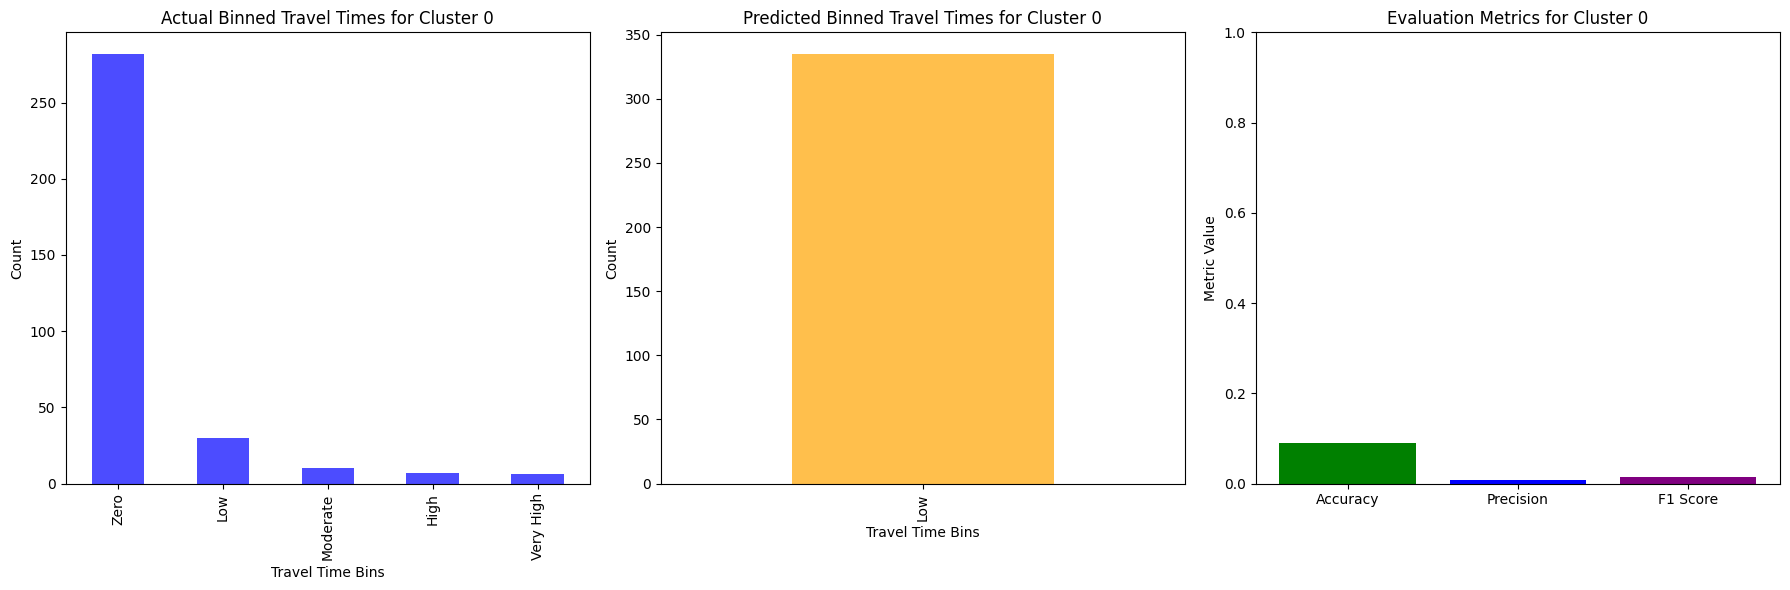

Processing Cluster 1


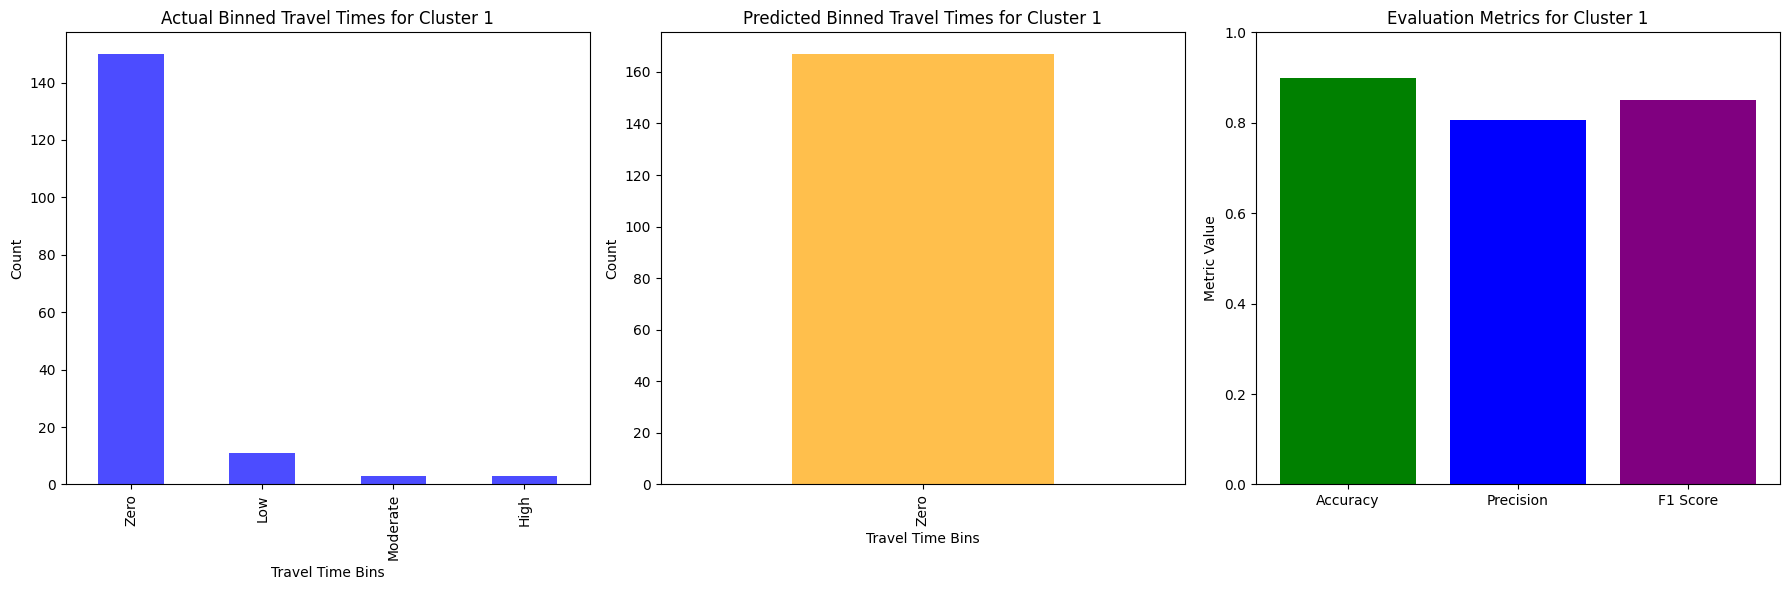

Processing Cluster 2


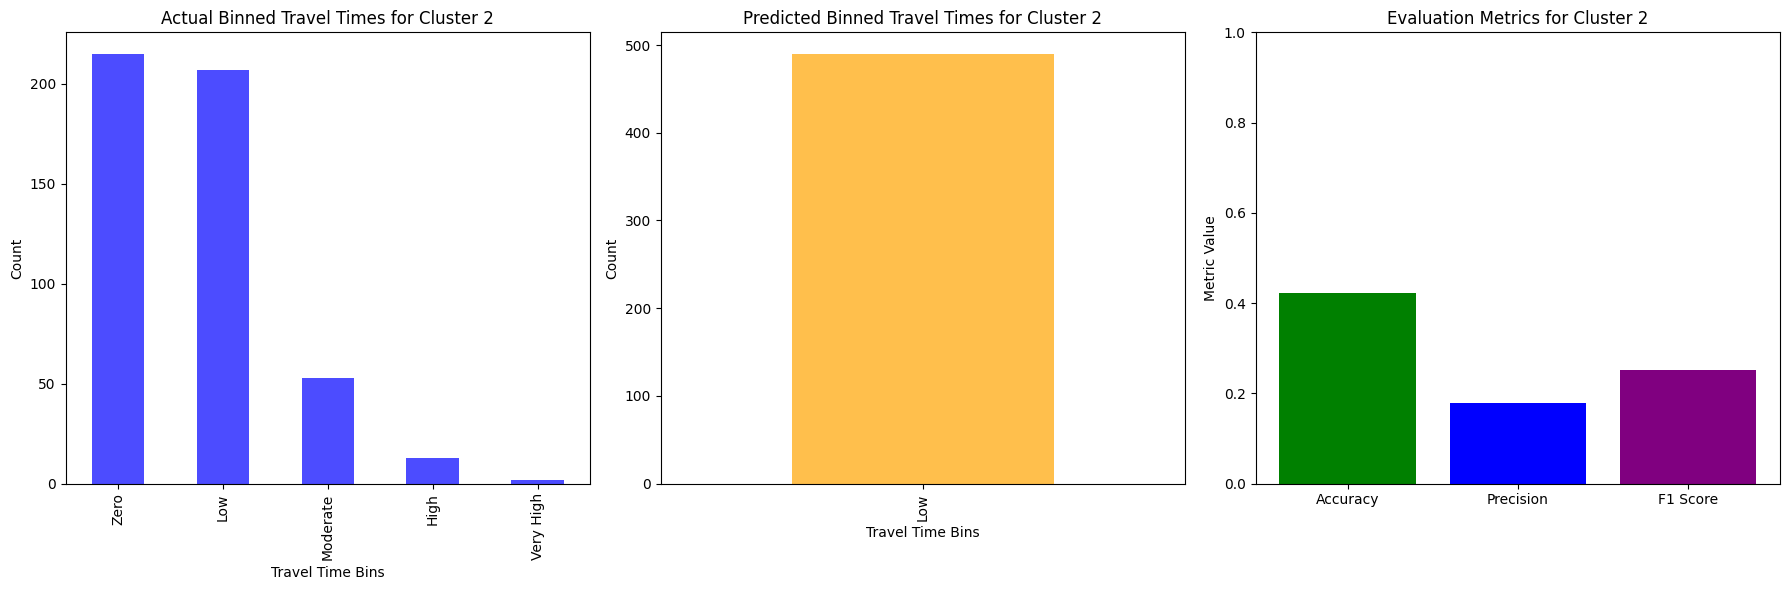

Cluster 0 Metrics:
  Accuracy: 0.08955223880597014
  Precision: 0.008019603475161506
  F1 Score: 0.014720915968104683
----------------------------------------
Cluster 1 Metrics:
  Accuracy: 0.8982035928143712
  Precision: 0.8067696941446448
  F1 Score: 0.8500349458811084
----------------------------------------
Cluster 2 Metrics:
  Accuracy: 0.42244897959183675
  Precision: 0.17846314035818409
  F1 Score: 0.2509237841478055
----------------------------------------


In [59]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# Define the evaluator objects for accuracy, precision, and F1 score
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="binned_travel_time_numeric", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="binned_travel_time_numeric", predictionCol="prediction", metricName="weightedPrecision")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="binned_travel_time_numeric", predictionCol="prediction", metricName="f1")

# Initialize empty lists to hold evaluation metrics for all clusters
cluster_metrics = []

# Iterate through each cluster for evaluation and visualization
for cluster_num in range(3):  
    print(f"Processing Cluster {cluster_num}")
    
    # Filter predictions for the current cluster
    cluster_data = combined_predictions.filter(F.col("cluster_pred") == cluster_num)
    
    # Evaluate the metrics using PySpark DataFrame
    accuracy = evaluator_accuracy.evaluate(cluster_data)
    precision = evaluator_precision.evaluate(cluster_data)
    f1_score = evaluator_f1.evaluate(cluster_data)
    
    # Save metrics for each cluster to display them later
    cluster_metrics.append((cluster_num, accuracy, precision, f1_score))
    
    # Convert to Pandas for plotting
    cluster_data_pandas = cluster_data.select('binned_travel_time_numeric', 'prediction').toPandas()

    # Map numeric bins back to categorical bins for easier visualization
    bin_mapping = {0: 'Zero', 1: 'Low', 2: 'Moderate', 3: 'High', 4: 'Very High'}
    cluster_data_pandas['actual_bins'] = cluster_data_pandas['binned_travel_time_numeric'].map(bin_mapping)
    cluster_data_pandas['predicted_bins'] = cluster_data_pandas['prediction'].map(bin_mapping)

    # Create the plot
    plt.figure(figsize=(18, 6))

    # Plot Actual Binned Travel Times
    plt.subplot(1, 3, 1)
    cluster_data_pandas['actual_bins'].value_counts().plot(kind='bar', color='blue', alpha=0.7)
    plt.title(f'Actual Binned Travel Times for Cluster {cluster_num}')
    plt.xlabel('Travel Time Bins')
    plt.ylabel('Count')

    # Plot Predicted Binned Travel Times
    plt.subplot(1, 3, 2)
    cluster_data_pandas['predicted_bins'].value_counts().plot(kind='bar', color='orange', alpha=0.7)
    plt.title(f'Predicted Binned Travel Times for Cluster {cluster_num}')
    plt.xlabel('Travel Time Bins')
    plt.ylabel('Count')

    # Display evaluation metrics in a separate subplot
    plt.subplot(1, 3, 3)
    plt.bar(['Accuracy', 'Precision', 'F1 Score'], [accuracy, precision, f1_score], color=['green', 'blue', 'purple'])
    plt.ylim(0, 1)  # Metrics are usually between 0 and 1
    plt.title(f'Evaluation Metrics for Cluster {cluster_num}')
    plt.ylabel('Metric Value')

    # Display the plots
    plt.tight_layout()
    plt.show()

#  print out the metrics for all clusters
for cluster_num, accuracy, precision, f1_score in cluster_metrics:
    print(f"Cluster {cluster_num} Metrics:")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  F1 Score: {f1_score}")
    print("-" * 40)


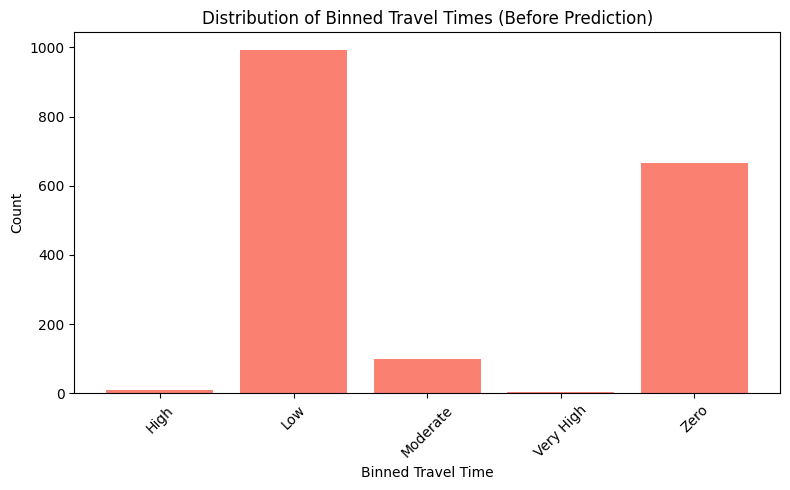

In [60]:
# Count the occurrences of each binned travel time category in the training data
binned_travel_time_distribution = df_with_clusters.groupBy('binned_travel_time') \
    .count() \
    .orderBy('binned_travel_time')

# Converted to Pandas for easier plotting
pandas_df = binned_travel_time_distribution.toPandas()

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(pandas_df['binned_travel_time'], pandas_df['count'], color='salmon')
plt.title('Distribution of Binned Travel Times (Before Prediction)')
plt.xlabel('Binned Travel Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ON TRAINING DATA

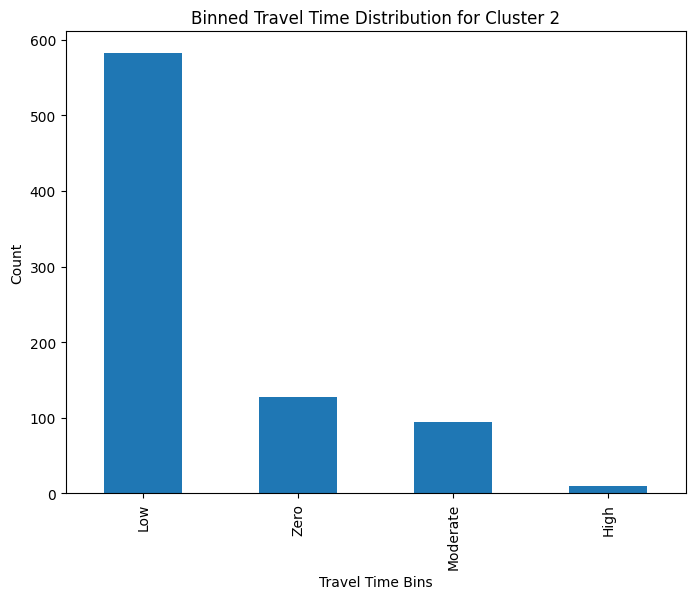

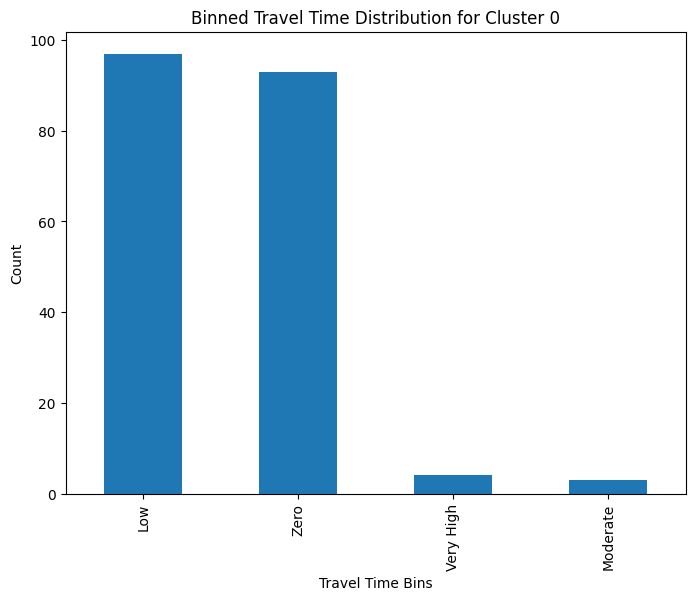

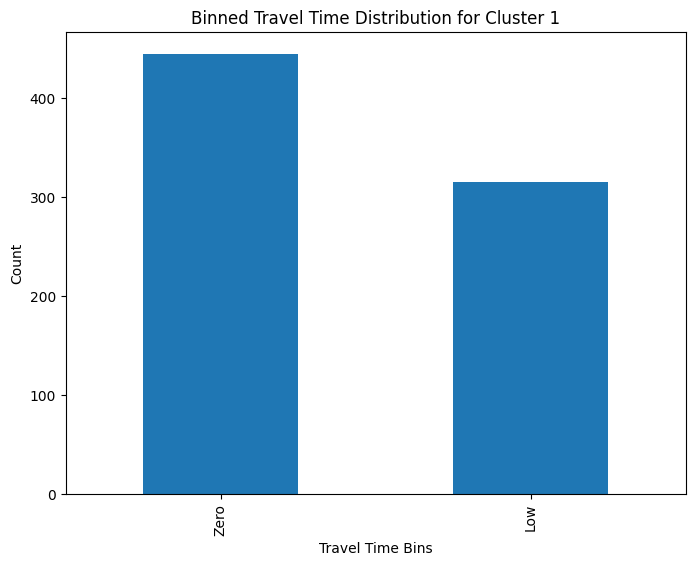

In [61]:

import matplotlib.pyplot as plt
import pandas as pd

# Convert the Spark DataFrame to a Pandas DataFrame for visualization
df_pandas = df_with_clusters.select('cluster_pred', 'binned_travel_time').toPandas()

# Loop through clusters and plot
for cluster_num in df_pandas['cluster_pred'].unique():
    cluster_data = df_pandas[df_pandas['cluster_pred'] == cluster_num]
    
    # Plotting the count of binned travel times for this cluster
    plt.figure(figsize=(8, 6))
    cluster_data['binned_travel_time'].value_counts().plot(kind='bar')
    plt.title(f'Binned Travel Time Distribution for Cluster {cluster_num}')
    plt.xlabel('Travel Time Bins')
    plt.ylabel('Count')
    plt.show()


ON TEST DATA

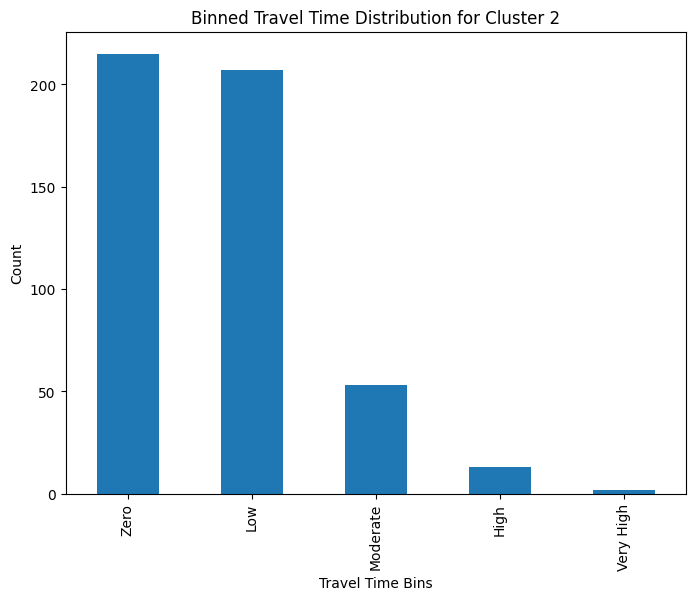

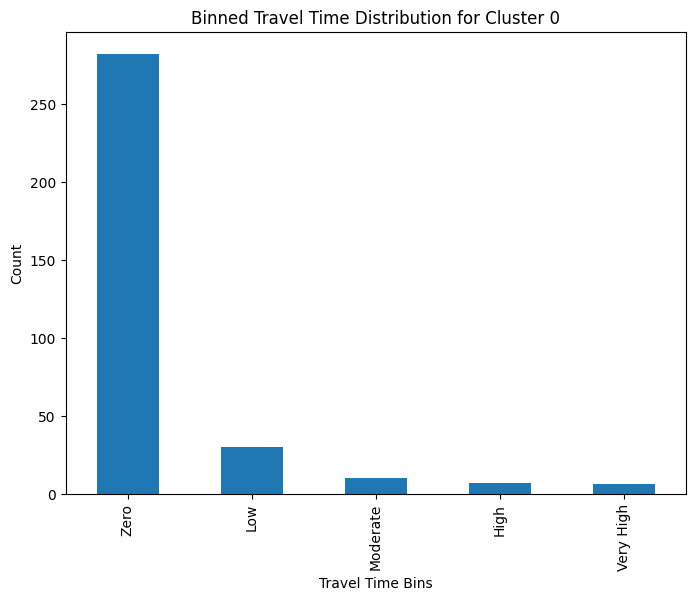

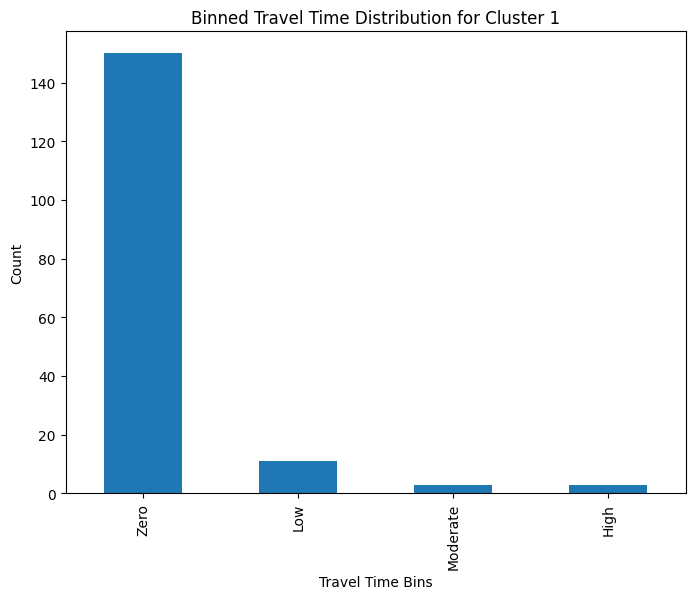

In [62]:

import matplotlib.pyplot as plt
import pandas as pd

# Convert the Spark DataFrame to a Pandas DataFrame for visualization
df_pandas = df_with_test_clusters_and_features.select('cluster_pred', 'binned_travel_time').toPandas()

# Loop through clusters and plot
for cluster_num in df_pandas['cluster_pred'].unique():
    cluster_data = df_pandas[df_pandas['cluster_pred'] == cluster_num]
    
    # Plotting the count of binned travel times for this cluster
    plt.figure(figsize=(8, 6))
    cluster_data['binned_travel_time'].value_counts().plot(kind='bar')
    plt.title(f'Binned Travel Time Distribution for Cluster {cluster_num}')
    plt.xlabel('Travel Time Bins')
    plt.ylabel('Count')
    plt.show()


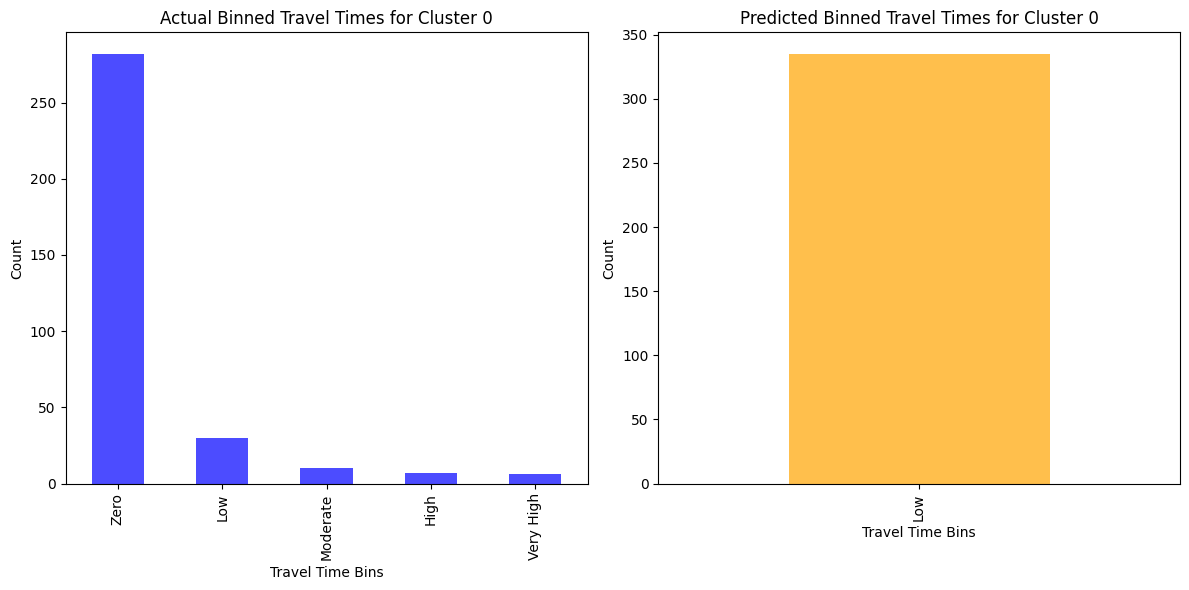

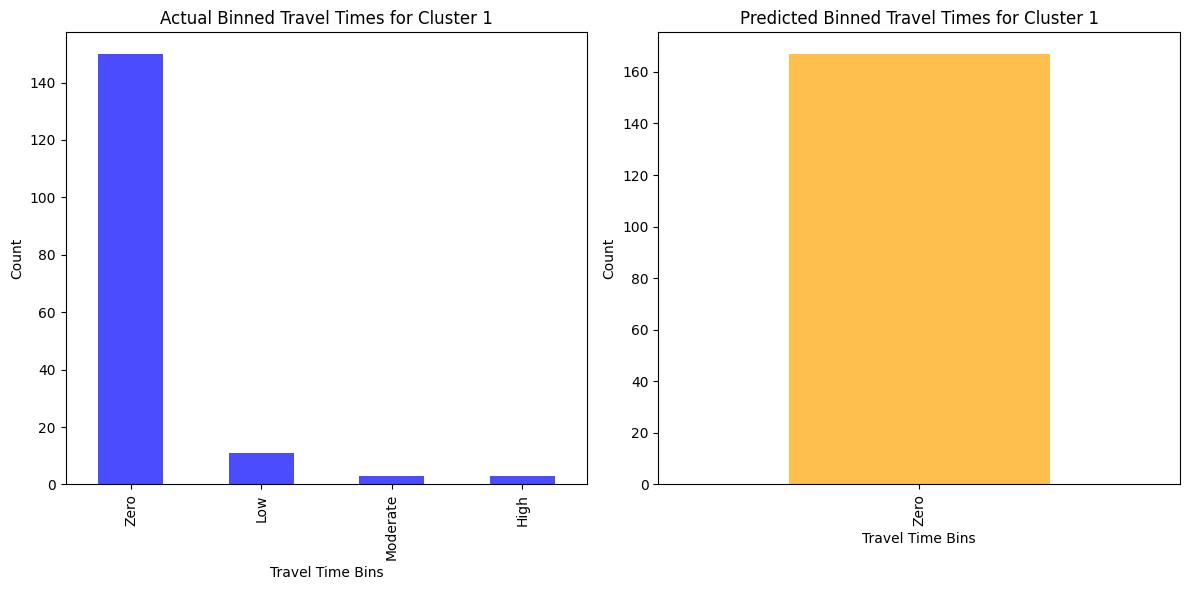

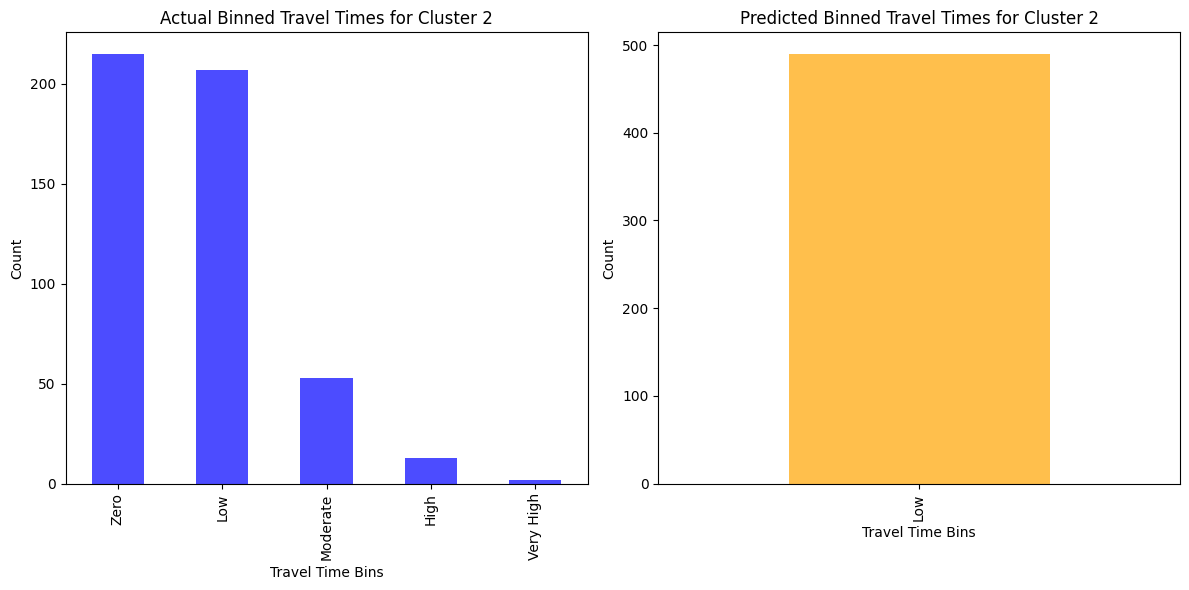

In [63]:
# Combine all cluster predictions into a single DataFrame
combined_predictions = all_predictions[0]
for cluster_pred in all_predictions[1:]:
    combined_predictions = combined_predictions.union(cluster_pred)

# Convert the combined predictions DataFrame to Pandas for visualization
predictions_pandas = combined_predictions.select('cluster_pred', 'binned_travel_time_numeric', 'prediction').toPandas()

# Mapping numeric bins back to categorical bins for easier visualization
bin_mapping = {0: 'Zero', 1: 'Low', 2: 'Moderate', 3: 'High', 4: 'Very High'}
predictions_pandas['actual_bins'] = predictions_pandas['binned_travel_time_numeric'].map(bin_mapping)
predictions_pandas['predicted_bins'] = predictions_pandas['prediction'].map(bin_mapping)

# Visualize for each cluster
for cluster_num in predictions_pandas['cluster_pred'].unique():
    cluster_data = predictions_pandas[predictions_pandas['cluster_pred'] == cluster_num]
    
    # Plotting actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    cluster_data['actual_bins'].value_counts().plot(kind='bar', color='blue', alpha=0.7)
    plt.title(f'Actual Binned Travel Times for Cluster {cluster_num}')
    plt.xlabel('Travel Time Bins')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    cluster_data['predicted_bins'].value_counts().plot(kind='bar', color='orange', alpha=0.7)
    plt.title(f'Predicted Binned Travel Times for Cluster {cluster_num}')
    plt.xlabel('Travel Time Bins')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

<!-- Evaluation -->


Distributed k-means algorithm --next_file